Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7194 - loss: 0.6697 - val_accuracy: 0.5000 - val_loss: 0.9222
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6900 - loss: 0.6627 - val_accuracy: 0.4600 - val_loss: 0.8252
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6448 - loss: 0.6804 - val_accuracy: 0.5000 - val_loss: 0.7625
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6466 - loss: 0.6788 - val_accuracy: 0.5600 - val_loss: 0.7209
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6106 - loss: 0.6492 - val_accuracy: 0.5800 - val_loss: 0.6984
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7159 - loss: 0.5447 - val_accuracy: 0.5800 - val_loss: 0.6788
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6559 - loss: 0.6269 - val_accuracy: 0.6200 - val_loss: 0.6596
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7082 - loss: 0.5174 - val_accuracy: 0.6200 - val_loss: 0.6460
E

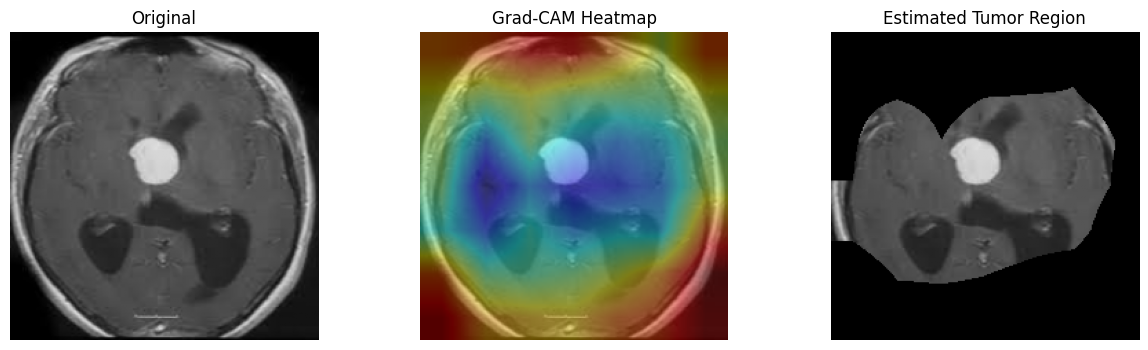

In [19]:
# ----------------------------------------
# 1. IMPORTS & SETUP
# ----------------------------------------
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tqdm import tqdm

# ----------------------------------------
# 2. LOAD DATA
# ----------------------------------------
IMG_SIZE = 224
DATA_DIR = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"

def load_data(data_dir):
    images = []
    labels = []
    for label, folder in enumerate(["no", "yes"]):  # 0: no tumor, 1: tumor
        path = os.path.join(data_dir, folder)
        for filename in os.listdir(path):
            if filename.lower().endswith(('.jpg', '.png')):
                img = cv2.imread(os.path.join(path, filename))
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

X, y = load_data(DATA_DIR)
X = X / 255.0
y_cat = to_categorical(y, num_classes=2)

X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=44)

# ----------------------------------------
# 3. BUILD MODEL (NO WARNING)
# ----------------------------------------
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

input_tensor = base_model.input
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output_tensor = Dense(2, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# ----------------------------------------
# 4. TRAINING
# ----------------------------------------
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# ----------------------------------------
# 5. EVALUATION
# ----------------------------------------
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"✅ Validation Accuracy: {val_acc:.4f}")

# ----------------------------------------
# 6. GRAD-CAM FUNCTION
# ----------------------------------------
def get_grad_cam(model, img_array, class_index, last_conv_layer_name="Conv_1"):
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img_array]))
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted((img * 255).astype(np.uint8), 1 - alpha, heatmap_colored, alpha, 0)
    return overlay

# ----------------------------------------
# 7. VISUALIZE GRAD-CAM + SEGMENTATION
# ----------------------------------------
def show_gradcam_and_segment(img):
    pred = model.predict(np.array([img]))
    pred_class = np.argmax(pred)

    heatmap = get_grad_cam(model, img, pred_class)
    overlay = overlay_heatmap(img, heatmap)

    # Segmentation mask (thresholded heatmap)
    heatmap_mask = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE)) > 0.5
    seg = img.copy()
    seg[~heatmap_mask] = 0

    # Plot
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(seg)
    plt.title("Estimated Tumor Region")
    plt.axis("off")
    plt.show()

# ----------------------------------------
# 8. RUN ON RANDOM VALIDATION SAMPLE
# ----------------------------------------
idx = np.random.randint(0, len(X_val))
show_gradcam_and_segment(X_val[idx])


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4650 - loss: 0.7972 - val_accuracy: 0.6200 - val_loss: 0.7249
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6563 - loss: 0.6472 - val_accuracy: 0.6000 - val_loss: 0.6119
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6988 - loss: 0.5824 - val_accuracy: 0.6800 - val_loss: 0.5441
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7709 - loss: 0.5165 - val_accuracy: 0.7400 - val_loss: 0.4891
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7407 - loss: 0.4944 - val_accuracy: 0.7600 - val_loss: 0.4521
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8070 - loss: 0.4098 - val_accuracy: 0.8000 - val_loss: 0.4188
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7996 - loss: 0.4135 - val_accuracy: 0.8200 - val_loss: 0.3900
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8453 - loss: 0.3852 - val_accuracy: 0.8200 - val_loss: 0.3695
E

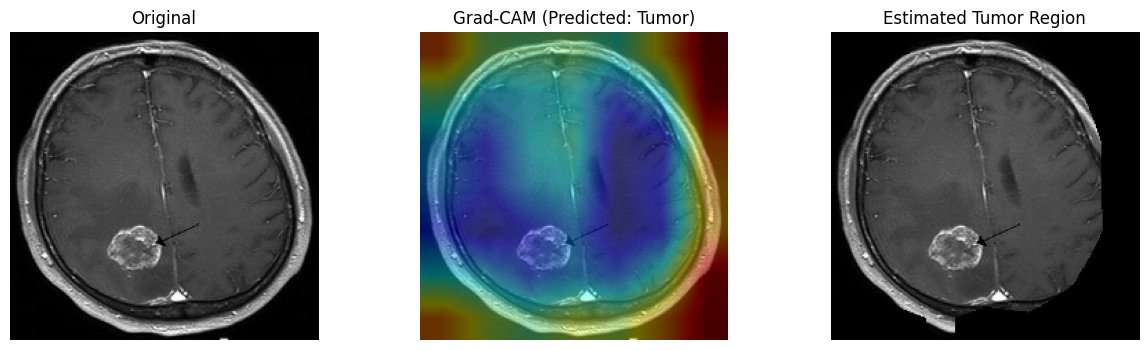

In [18]:
# ----------------------------------------
# 1. IMPORTS & SETUP
# ----------------------------------------
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# ----------------------------------------
# 2. LOAD DATA
# ----------------------------------------
IMG_SIZE = 224
DATA_DIR = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"

def load_data(data_dir):
    images = []
    labels = []
    for label, folder in enumerate(["no", "yes"]):  # 0: no tumor, 1: tumor
        path = os.path.join(data_dir, folder)
        for filename in os.listdir(path):
            if filename.lower().endswith(('.jpg', '.png')):
                img = cv2.imread(os.path.join(path, filename))
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

X, y = load_data(DATA_DIR)
X = X / 255.0

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------------------
# 3. BUILD MODEL (SIGMOID VERSION)
# ----------------------------------------
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output_tensor = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output_tensor)
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# ----------------------------------------
# 4. TRAINING
# ----------------------------------------
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# ----------------------------------------
# 5. EVALUATION
# ----------------------------------------
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"✅ Validation Accuracy: {val_acc:.4f}")

# ----------------------------------------
# 6. GRAD-CAM FUNCTION
# ----------------------------------------
def get_grad_cam(model, img_array, class_index, last_conv_layer_name="Conv_1"):
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img_array]))
        loss = predictions[:, 0]  # single output neuron

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted((img * 255).astype(np.uint8), 1 - alpha, heatmap_colored, alpha, 0)
    return overlay

# ----------------------------------------
# 7. VISUALIZE GRAD-CAM + SEGMENTATION
# ----------------------------------------
def show_gradcam_and_segment(img):
    pred = model.predict(np.array([img]))[0][0]
    pred_class = 1 if pred >= 0.5 else 0

    heatmap = get_grad_cam(model, img, pred_class)
    overlay = overlay_heatmap(img, heatmap)

    heatmap_mask = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE)) > 0.5
    seg = img.copy()
    seg[~heatmap_mask] = 0

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM (Predicted: {'Tumor' if pred_class == 1 else 'No Tumor'})")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(seg)
    plt.title("Estimated Tumor Region")
    plt.axis("off")
    plt.show()

# ----------------------------------------
# 8. RUN ON RANDOM VALIDATION SAMPLE
# ----------------------------------------
idx = np.random.randint(0, len(X_val))
show_gradcam_and_segment(X_val[idx])


Loading data...
Loading no images...


100%|██████████| 98/98 [00:00<00:00, 374.32it/s]


Loading yes images...


100%|██████████| 155/155 [00:00<00:00, 371.43it/s]


Loaded 247 images total
No tumor: 92 images
Tumor: 155 images
Training set: 197 samples
Validation set: 50 samples

TRAINING MODEL 1: CATEGORICAL CROSSENTROPY
Model 1 Architecture:


Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_26[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5626 - loss: 0.7864 - val_accuracy: 0.6200 - val_loss: 0.7260
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5324 - loss: 0.7632 - val_accuracy: 0.6800 - val_loss: 0.7081
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6235 - loss: 0.6930 - val_accuracy: 0.7000 - val_loss: 0.6924
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5695 - loss: 0.7409 - val_accuracy: 0.7000 - val_loss: 0.6774
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5733 - loss: 0.7500 - val_accuracy: 0.7000 - val_loss: 0.6641
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6492 - loss: 0.6941 - val_accuracy: 0.7000 - val_loss: 0.6513
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6267 - loss: 0.6841 - val_accuracy: 0.7000 - val_loss: 0.6401
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5715 - loss: 0.7311 - val_accuracy: 0.7200 - val_loss: 0.6295
E

Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Training with class weights to handle imbalance...
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5001 - loss: 0.7819 - precision: 0.6116 - recall: 0.5599 - val_accuracy: 0.5600 - val_loss: 0.7061 - val_precision: 0.6364 - val_recall: 0.6774 - learning_rate: 0.0010
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6050 - loss: 0.7056 - precision: 0.6830 - recall: 0.6806 - val_accuracy: 0.6200 - val_loss: 0.6318 - val_precision: 0.7000 - val_recall: 0.6774 - learning_rate: 0.0010
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6199 - loss: 0.6395 - precision: 0.7270 - recall: 0.6174 - val_accuracy: 0.6800 - val_loss: 0.5891 - val_precision: 0.7586 - val_recall: 0.7097 - learning_rate: 0.0010
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7303 - loss: 0.5346 - precision: 0.8271 - recall: 0.7145 - val_accuracy: 0.7600 - val_loss: 0.5580 - val_precision: 0.8276 - val_recall: 0.7742 - learning_rate: 0.0010
Epoch 5/20
7/7 ━━━━━━━━━━━

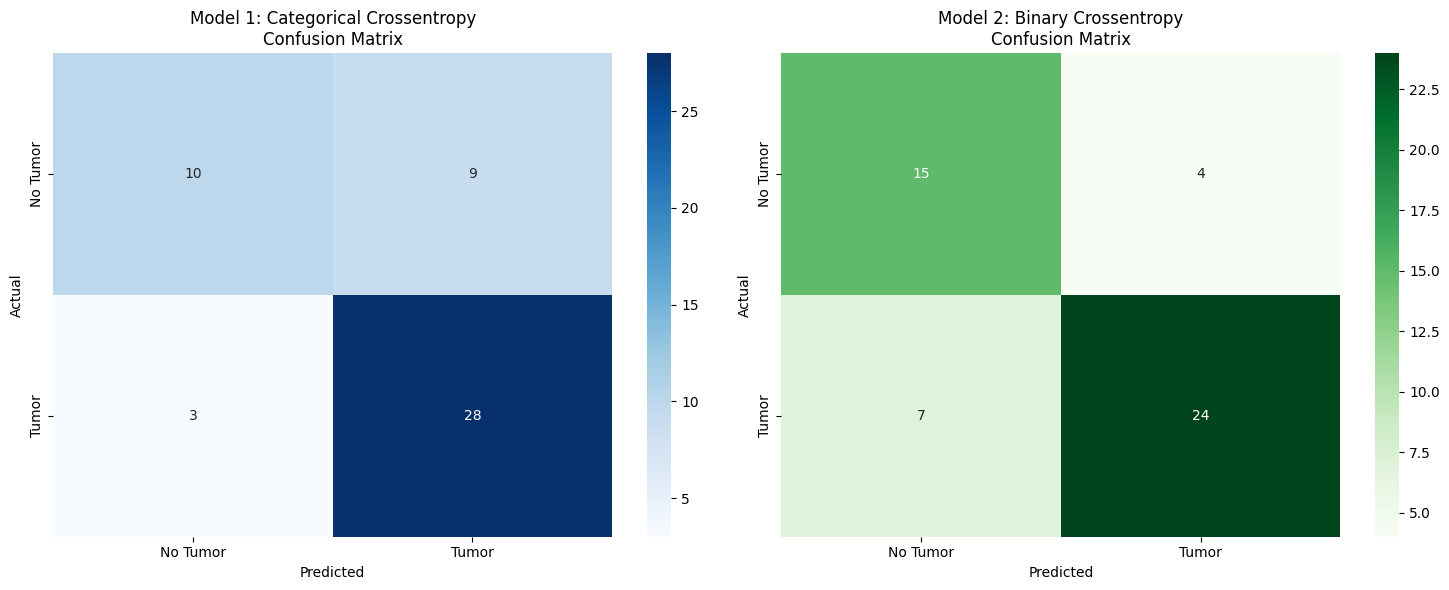


CLASSIFICATION REPORTS:

Model 1 (Categorical Crossentropy):
              precision    recall  f1-score   support

    No Tumor       0.77      0.53      0.62        19
       Tumor       0.76      0.90      0.82        31

    accuracy                           0.76        50
   macro avg       0.76      0.71      0.72        50
weighted avg       0.76      0.76      0.75        50


Model 2 (Binary Crossentropy):
              precision    recall  f1-score   support

    No Tumor       0.68      0.79      0.73        19
       Tumor       0.86      0.77      0.81        31

    accuracy                           0.78        50
   macro avg       0.77      0.78      0.77        50
weighted avg       0.79      0.78      0.78        50



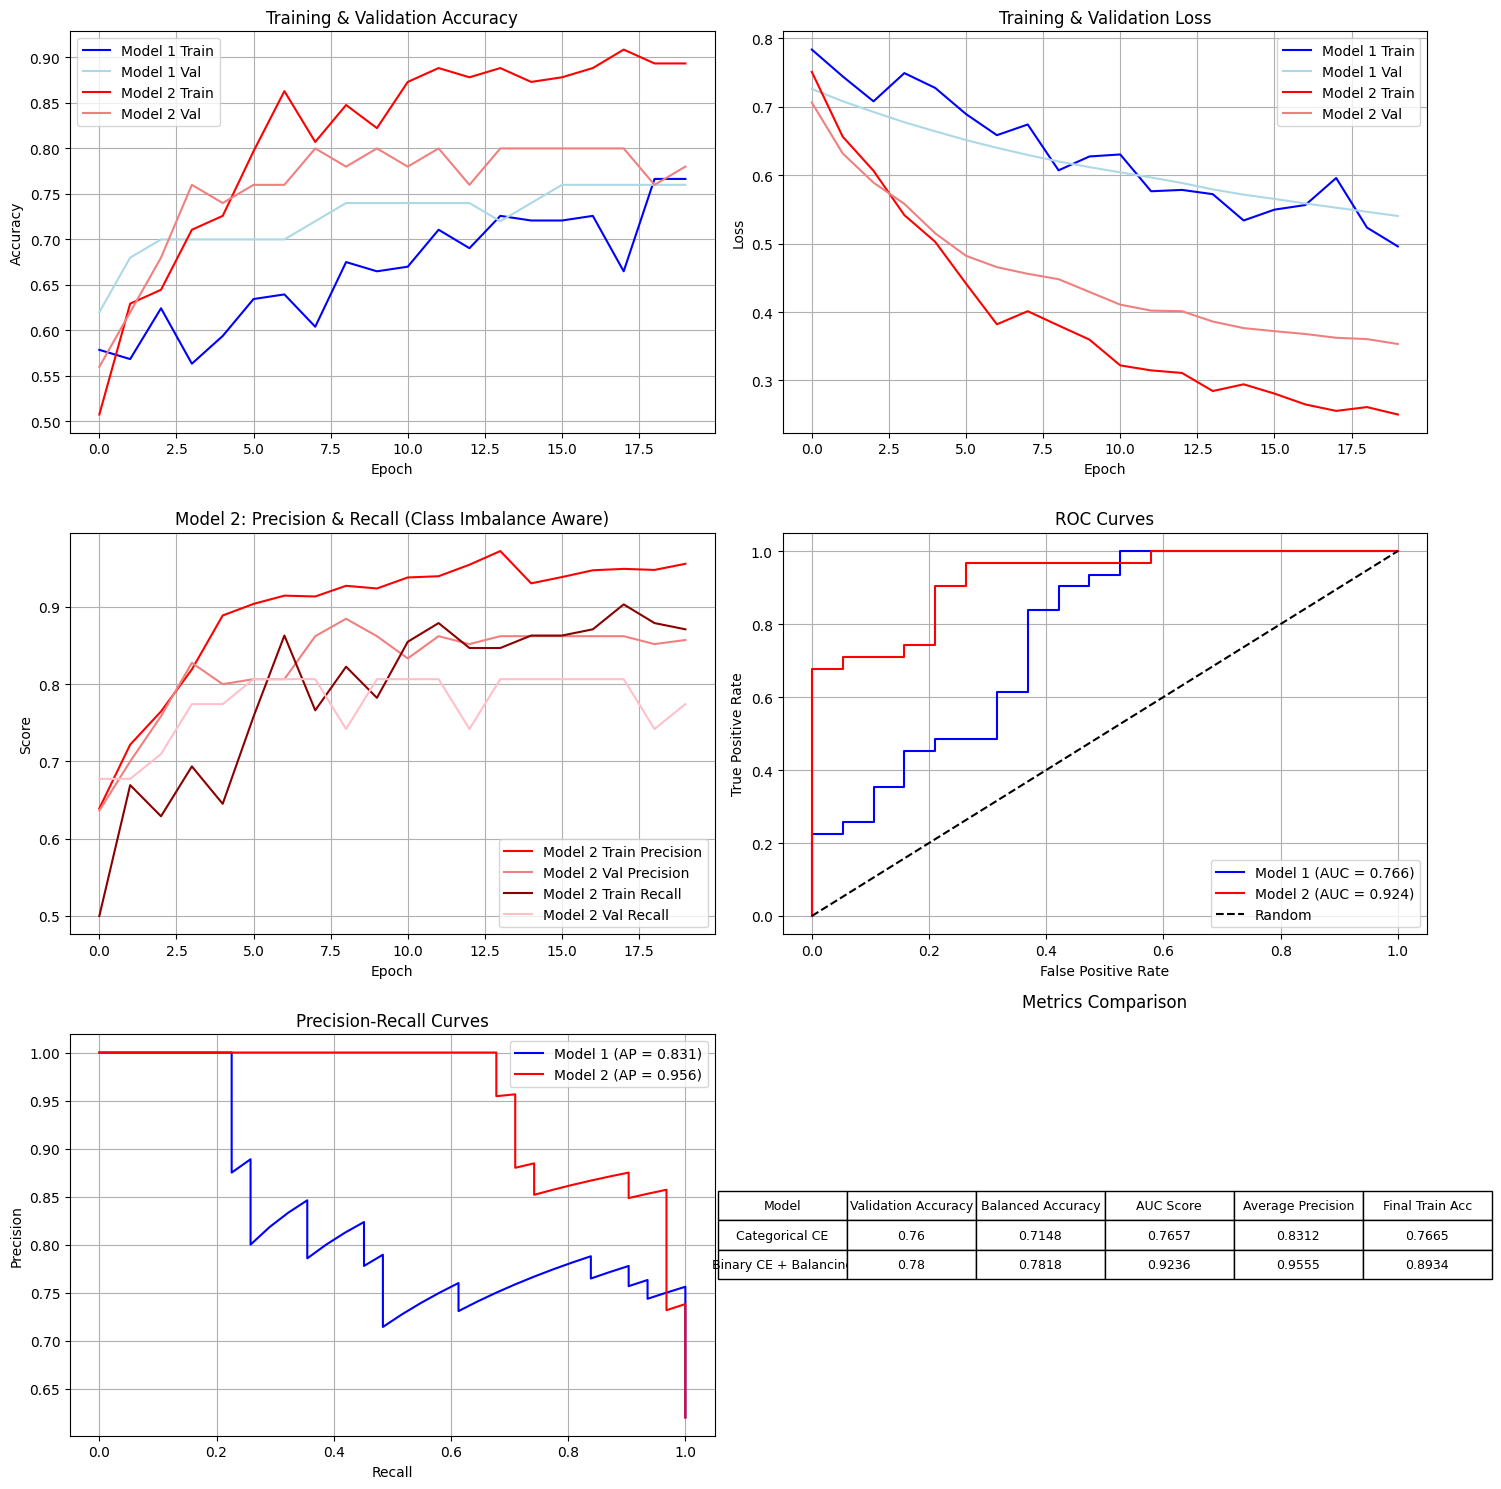


DETAILED METRICS COMPARISON
                      Model 1 (Categorical CE)  \
Accuracy                                0.7600   
Balanced Accuracy                       0.7148   
Precision                               0.7568   
Recall (Sensitivity)                    0.9032   
Specificity                             0.5263   
F1-Score                                0.8235   
AUC                                     0.7657   
Average Precision                       0.8312   

                      Model 2 (Binary CE + Balancing)  
Accuracy                                       0.7800  
Balanced Accuracy                              0.7818  
Precision                                      0.8571  
Recall (Sensitivity)                           0.7742  
Specificity                                    0.7895  
F1-Score                                       0.8136  
AUC                                            0.9236  
Average Precision                              0.9555  

CLASS IMBALANCE

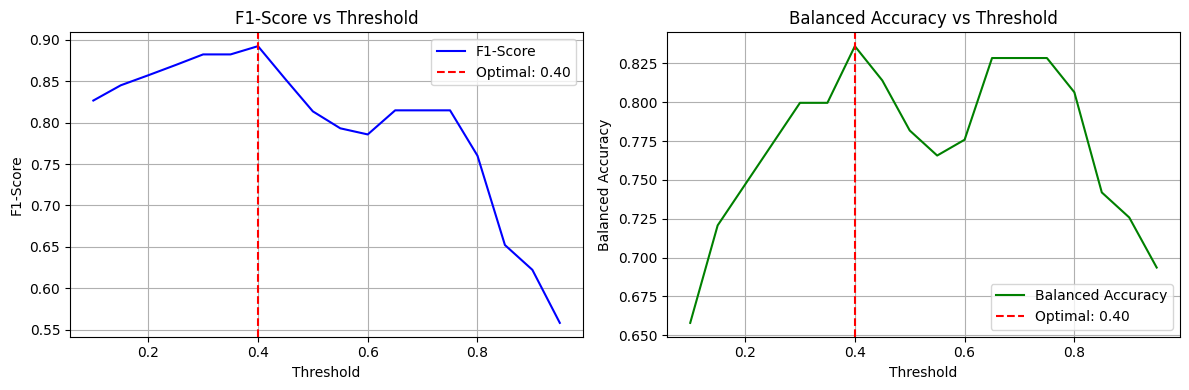


GRAD-CAM VISUALIZATION COMPARISON

Sample 1:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


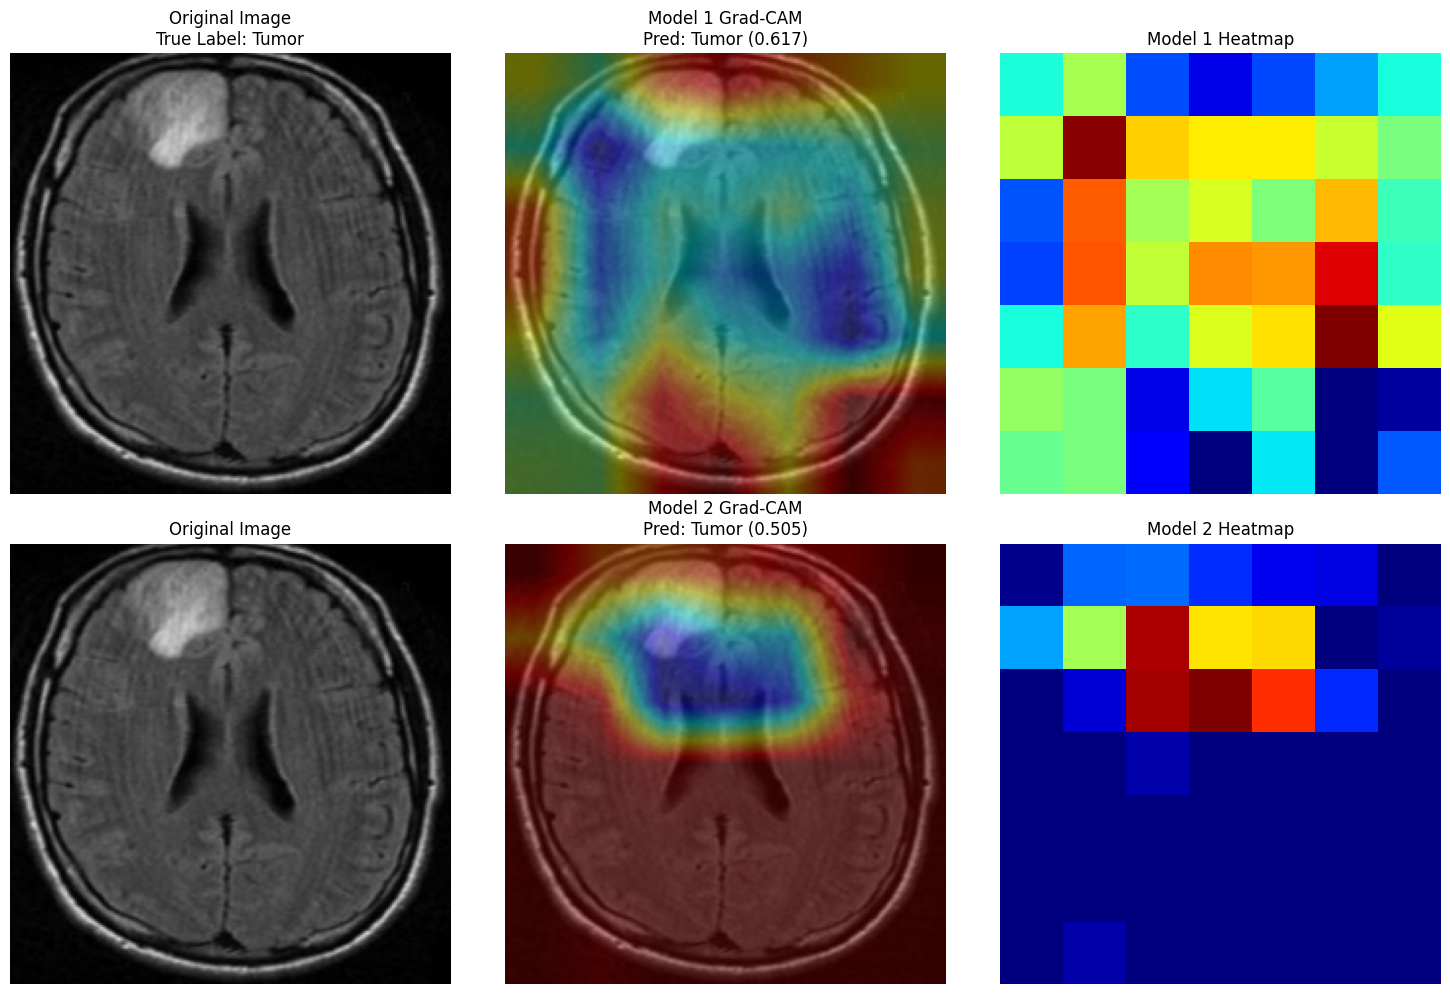


Sample 2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


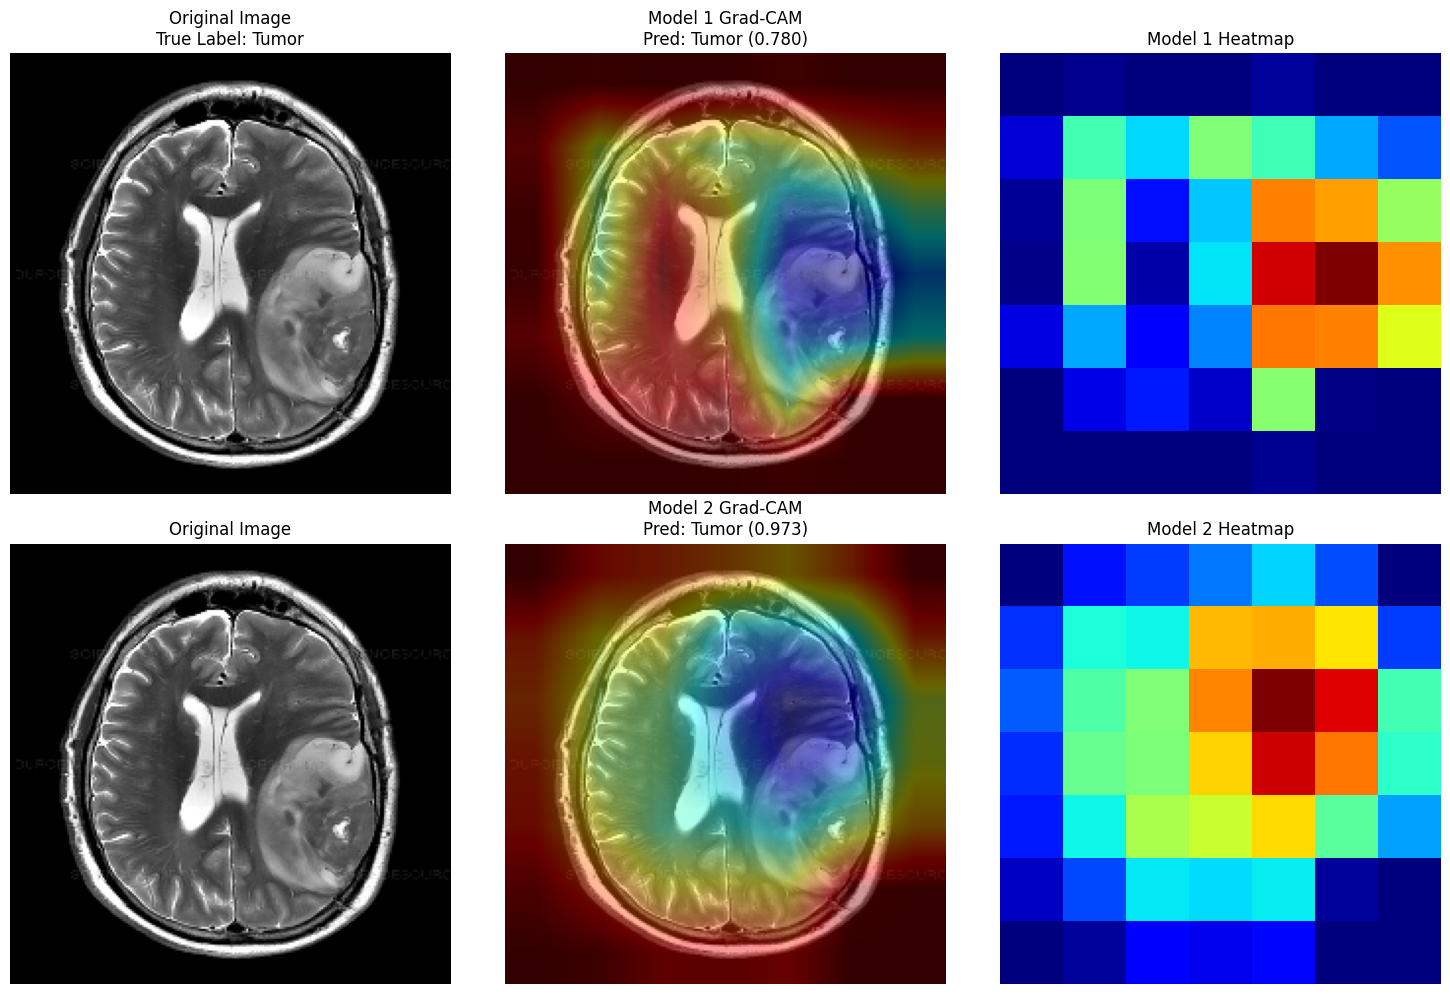


Sample 3:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


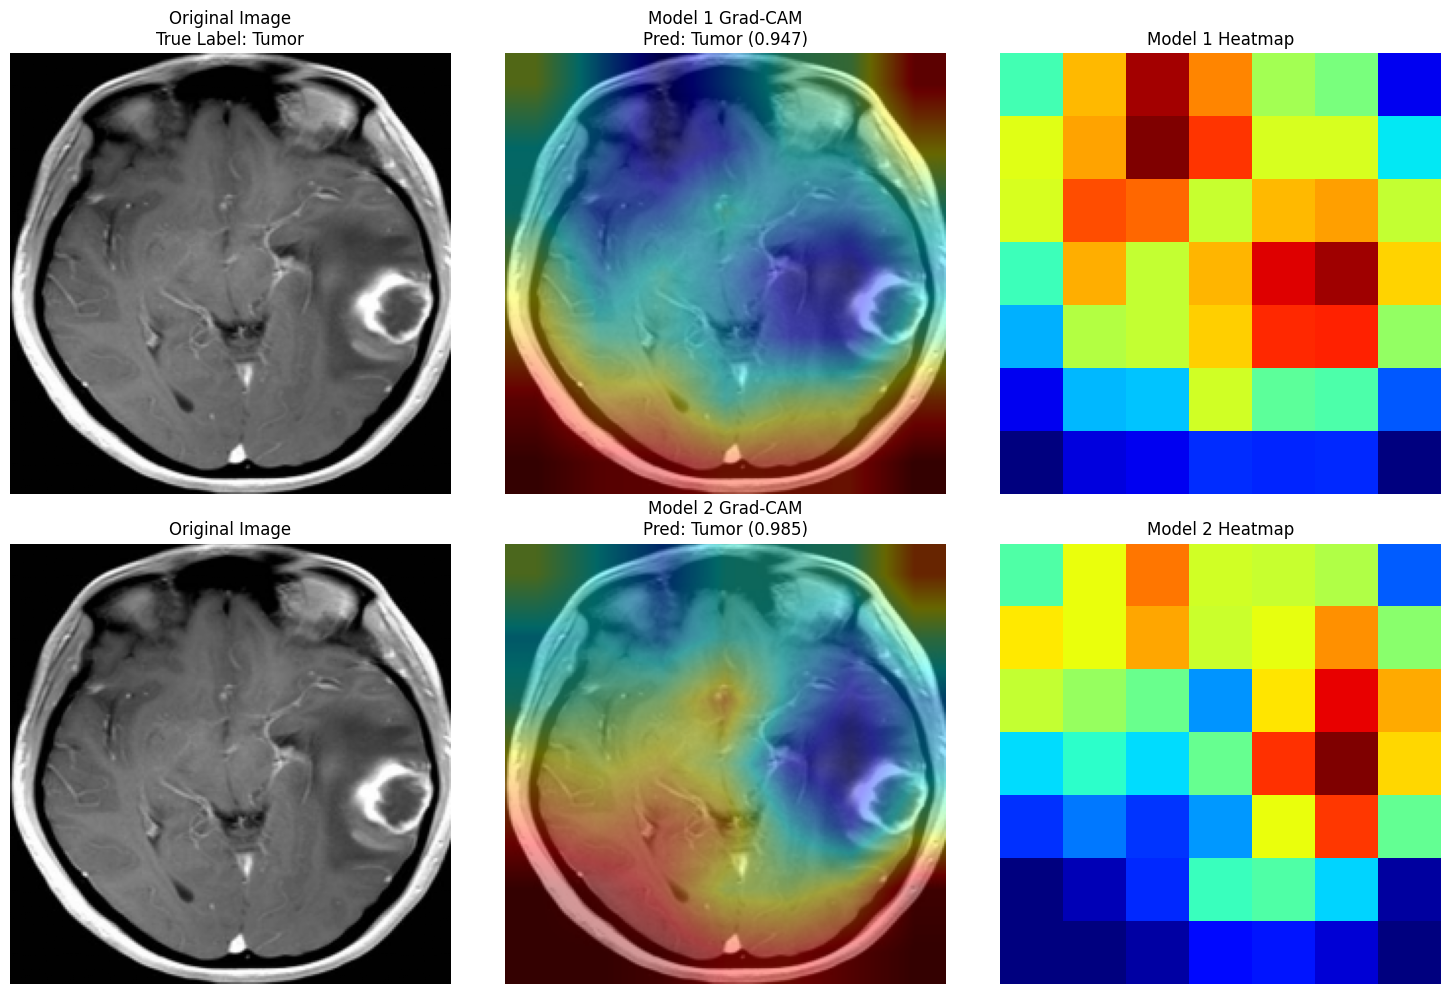


FINAL ANALYSIS AND RECOMMENDATION

PERFORMANCE SUMMARY:
Model 1 (Categorical Crossentropy + Softmax):
- Validation Accuracy: 0.7600
- Balanced Accuracy: 0.7148
- AUC Score: 0.7657
- Learning Rate: 0.0001
- Epochs: 20

Model 2 (Binary Crossentropy + Sigmoid + Class Balancing):
- Validation Accuracy: 0.7800
- Balanced Accuracy: 0.7818
- AUC Score: 0.9236
- Learning Rate: 0.001
- Epochs: 20
- Class Weights: {0: 1.3493150684931507, 1: 0.7943548387096774}

TECHNICAL DIFFERENCES:
1. OUTPUT LAYER:
   - Model 1: 2 neurons with softmax (probability distribution)
   - Model 2: 1 neuron with sigmoid (binary probability)

2. LOSS FUNCTION:
   - Model 1: Categorical crossentropy
   - Model 2: Binary crossentropy with class weights

3. CLASS IMBALANCE HANDLING:
   - Model 1: No specific handling
   - Model 2: Class weights, early stopping, learning rate reduction

4. LEARNING RATE:
   - Model 1: 0.0001 (lower)
   - Model 2: 0.001 (higher, with reduction on plateau)

5. EVALUATION METRICS:
   - Mode

In [23]:
# ----------------------------------------
# COMPREHENSIVE BRAIN TUMOR DETECTION MODEL COMPARISON
# ----------------------------------------

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tqdm import tqdm
import pandas as pd

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ----------------------------------------
# 1. DATA LOADING AND PREPROCESSING
# ----------------------------------------
IMG_SIZE = 224
DATA_DIR = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"

def load_data(data_dir):
    """Load and preprocess brain MRI images"""
    images = []
    labels = []
    print("Loading data...")
    
    for label, folder in enumerate(["no", "yes"]):  # 0: no tumor, 1: tumor
        path = os.path.join(data_dir, folder)
        print(f"Loading {folder} images...")
        
        for filename in tqdm(os.listdir(path)):
            if filename.lower().endswith(('.jpg', '.png')):
                img = cv2.imread(os.path.join(path, filename))
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)
                labels.append(label)
    
    print(f"Loaded {len(images)} images total")
    print(f"No tumor: {sum(1 for l in labels if l == 0)} images")
    print(f"Tumor: {sum(1 for l in labels if l == 1)} images")
    
    return np.array(images), np.array(labels)

# Load data
X, y = load_data(DATA_DIR)
X = X / 255.0  # Normalize pixel values

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")

# ----------------------------------------
# 2. MODEL 1: CATEGORICAL CROSSENTROPY (SOFTMAX)
# ----------------------------------------
print("\n" + "="*50)
print("TRAINING MODEL 1: CATEGORICAL CROSSENTROPY")
print("="*50)

# Prepare categorical labels for model 1
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)

# Build Model 1
base_model_1 = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model_1.trainable = False

input_tensor_1 = base_model_1.input
x1 = base_model_1.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dropout(0.3)(x1)
output_tensor_1 = Dense(2, activation='softmax')(x1)

model_1 = Model(inputs=input_tensor_1, outputs=output_tensor_1)
model_1.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print("Model 1 Architecture:")
model_1.summary()

# Train Model 1
history_1 = model_1.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate Model 1
val_loss_1, val_acc_1 = model_1.evaluate(X_val, y_val_cat, verbose=0)
print(f"Model 1 - Validation Loss: {val_loss_1:.4f}, Validation Accuracy: {val_acc_1:.4f}")

# ----------------------------------------
# 3. MODEL 2: BINARY CROSSENTROPY WITH CLASS IMBALANCE HANDLING
# ----------------------------------------
print("\n" + "="*50)
print("TRAINING MODEL 2: BINARY CROSSENTROPY WITH CLASS BALANCING")
print("="*50)

# Calculate class distribution and weights for handling imbalance
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import balanced_accuracy_score, precision_recall_curve, average_precision_score

unique_classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
class_weight_dict = dict(zip(unique_classes, class_weights))

print(f"Class distribution in training set:")
print(f"No Tumor (0): {sum(y_train == 0)} samples")
print(f"Tumor (1): {sum(y_train == 1)} samples")
print(f"Class weights: {class_weight_dict}")

# Build Model 2 with class imbalance handling
base_model_2 = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model_2.trainable = False

x2 = base_model_2.output
x2 = GlobalAveragePooling2D()(x2)
x2 = Dropout(0.3)(x2)
output_tensor_2 = Dense(1, activation='sigmoid')(x2)

model_2 = Model(inputs=base_model_2.input, outputs=output_tensor_2)

# Use additional metrics for imbalanced classification
from tensorflow.keras.metrics import Precision, Recall

model_2.compile(
    optimizer=Adam(0.001), 
    loss='binary_crossentropy', 
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

print("Model 2 Architecture:")
model_2.summary()

# Callbacks for better training
callbacks_2 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

# Train Model 2 with class weights
print("Training with class weights to handle imbalance...")
history_2 = model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Using same epochs for fair comparison
    batch_size=32,
    class_weight=class_weight_dict,  # Handle class imbalance
    callbacks=callbacks_2,
    verbose=1
)

# Evaluate Model 2
val_loss_2, val_acc_2, val_precision_2, val_recall_2 = model_2.evaluate(X_val, y_val, verbose=0)
print(f"Model 2 - Validation Loss: {val_loss_2:.4f}")
print(f"Model 2 - Validation Accuracy: {val_acc_2:.4f}")
print(f"Model 2 - Validation Precision: {val_precision_2:.4f}")
print(f"Model 2 - Validation Recall: {val_recall_2:.4f}")

# ----------------------------------------
# 4. DETAILED COMPARISON AND ANALYSIS
# ----------------------------------------
print("\n" + "="*50)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*50)

# Get predictions
y_pred_1_prob = model_1.predict(X_val)
y_pred_1 = np.argmax(y_pred_1_prob, axis=1)

y_pred_2_prob = model_2.predict(X_val)
y_pred_2 = (y_pred_2_prob > 0.5).astype(int).flatten()

# Calculate balanced accuracy for Model 2 (better for imbalanced datasets)
balanced_acc_1 = balanced_accuracy_score(y_val, y_pred_1)
balanced_acc_2 = balanced_accuracy_score(y_val, y_pred_2)

print(f"Model 1 - Balanced Accuracy: {balanced_acc_1:.4f}")
print(f"Model 2 - Balanced Accuracy: {balanced_acc_2:.4f}")

# ----------------------------------------
# 5. CONFUSION MATRICES
# ----------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Model 1 Confusion Matrix
cm1 = confusion_matrix(y_val, y_pred_1)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Model 1: Categorical Crossentropy\nConfusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['No Tumor', 'Tumor'])
axes[0].set_yticklabels(['No Tumor', 'Tumor'])

# Model 2 Confusion Matrix
cm2 = confusion_matrix(y_val, y_pred_2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Model 2: Binary Crossentropy\nConfusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['No Tumor', 'Tumor'])
axes[1].set_yticklabels(['No Tumor', 'Tumor'])

plt.tight_layout()
plt.show()

# ----------------------------------------
# 6. CLASSIFICATION REPORTS
# ----------------------------------------
print("\nCLASSIFICATION REPORTS:")
print("\nModel 1 (Categorical Crossentropy):")
print(classification_report(y_val, y_pred_1, target_names=['No Tumor', 'Tumor']))

print("\nModel 2 (Binary Crossentropy):")
print(classification_report(y_val, y_pred_2, target_names=['No Tumor', 'Tumor']))

# ----------------------------------------
# 7. TRAINING HISTORY COMPARISON
# ----------------------------------------
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Training Accuracy
axes[0,0].plot(history_1.history['accuracy'], label='Model 1 Train', color='blue')
axes[0,0].plot(history_1.history['val_accuracy'], label='Model 1 Val', color='lightblue')
axes[0,0].plot(history_2.history['accuracy'], label='Model 2 Train', color='red')
axes[0,0].plot(history_2.history['val_accuracy'], label='Model 2 Val', color='lightcoral')
axes[0,0].set_title('Training & Validation Accuracy')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].grid(True)

# Training Loss
axes[0,1].plot(history_1.history['loss'], label='Model 1 Train', color='blue')
axes[0,1].plot(history_1.history['val_loss'], label='Model 1 Val', color='lightblue')
axes[0,1].plot(history_2.history['loss'], label='Model 2 Train', color='red')
axes[0,1].plot(history_2.history['val_loss'], label='Model 2 Val', color='lightcoral')
axes[0,1].set_title('Training & Validation Loss')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True)

# Precision and Recall for Model 2 (class imbalance aware)
if 'precision' in history_2.history:
    axes[1,0].plot(history_2.history['precision'], label='Model 2 Train Precision', color='red')
    axes[1,0].plot(history_2.history['val_precision'], label='Model 2 Val Precision', color='lightcoral')
    axes[1,0].plot(history_2.history['recall'], label='Model 2 Train Recall', color='darkred')
    axes[1,0].plot(history_2.history['val_recall'], label='Model 2 Val Recall', color='pink')
    axes[1,0].set_title('Model 2: Precision & Recall (Class Imbalance Aware)')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Score')
    axes[1,0].legend()
    axes[1,0].grid(True)

# ROC Curves
fpr1, tpr1, _ = roc_curve(y_val, y_pred_1_prob[:, 1])
auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_val, y_pred_2_prob)
auc2 = auc(fpr2, tpr2)

axes[1,1].plot(fpr1, tpr1, label=f'Model 1 (AUC = {auc1:.3f})', color='blue')
axes[1,1].plot(fpr2, tpr2, label=f'Model 2 (AUC = {auc2:.3f})', color='red')
axes[1,1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1,1].set_title('ROC Curves')
axes[1,1].set_xlabel('False Positive Rate')
axes[1,1].set_ylabel('True Positive Rate')
axes[1,1].legend()
axes[1,1].grid(True)

# Precision-Recall Curves (better for imbalanced datasets)
precision1, recall1, _ = precision_recall_curve(y_val, y_pred_1_prob[:, 1])
ap1 = average_precision_score(y_val, y_pred_1_prob[:, 1])

precision2, recall2, _ = precision_recall_curve(y_val, y_pred_2_prob)
ap2 = average_precision_score(y_val, y_pred_2_prob)

axes[2,0].plot(recall1, precision1, label=f'Model 1 (AP = {ap1:.3f})', color='blue')
axes[2,0].plot(recall2, precision2, label=f'Model 2 (AP = {ap2:.3f})', color='red')
axes[2,0].set_title('Precision-Recall Curves')
axes[2,0].set_xlabel('Recall')
axes[2,0].set_ylabel('Precision')
axes[2,0].legend()
axes[2,0].grid(True)

# Final Metrics Comparison
metrics_data = {
    'Model': ['Categorical CE', 'Binary CE + Balancing'],
    'Validation Accuracy': [val_acc_1, val_acc_2],
    'Balanced Accuracy': [balanced_acc_1, balanced_acc_2],
    'AUC Score': [auc1, auc2],
    'Average Precision': [ap1, ap2],
    'Final Train Acc': [history_1.history['accuracy'][-1], history_2.history['accuracy'][-1]]
}

df_metrics = pd.DataFrame(metrics_data)
axes[2,1].axis('tight')
axes[2,1].axis('off')
table = axes[2,1].table(cellText=df_metrics.round(4).values, colLabels=df_metrics.columns, 
                       cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)
axes[2,1].set_title('Metrics Comparison', pad=20)

plt.tight_layout()
plt.show()

# ----------------------------------------
# 8. DETAILED METRICS CALCULATION
# ----------------------------------------
def calculate_metrics(y_true, y_pred, y_pred_prob=None):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    
    metrics = {
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_acc,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1-Score': f1
    }
    
    # Add probability-based metrics if available
    if y_pred_prob is not None:
        auc_score = roc_auc_score(y_true, y_pred_prob)
        ap_score = average_precision_score(y_true, y_pred_prob)
        metrics['AUC'] = auc_score
        metrics['Average Precision'] = ap_score
    
    return metrics

from sklearn.metrics import roc_auc_score

metrics_1 = calculate_metrics(y_val, y_pred_1, y_pred_1_prob[:, 1])
metrics_2 = calculate_metrics(y_val, y_pred_2, y_pred_2_prob.flatten())

print("\n" + "="*50)
print("DETAILED METRICS COMPARISON")
print("="*50)

comparison_df = pd.DataFrame({
    'Model 1 (Categorical CE)': metrics_1,
    'Model 2 (Binary CE + Balancing)': metrics_2
}).round(4)

print(comparison_df)

# Additional analysis for class imbalance
print("\n" + "="*50)
print("CLASS IMBALANCE ANALYSIS")
print("="*50)

print(f"Original class distribution:")
print(f"Training - No Tumor: {sum(y_train == 0)}, Tumor: {sum(y_train == 1)}")
print(f"Validation - No Tumor: {sum(y_val == 0)}, Tumor: {sum(y_val == 1)}")

print(f"\nClass weights used in Model 2: {class_weight_dict}")

# Per-class performance analysis
print(f"\nPer-class performance comparison:")
print("\nModel 1:")
print(classification_report(y_val, y_pred_1, target_names=['No Tumor', 'Tumor']))

print("\nModel 2 (with class balancing):")
print(classification_report(y_val, y_pred_2, target_names=['No Tumor', 'Tumor']))

# Optimal threshold analysis for Model 2
print("\n" + "="*50)
print("OPTIMAL THRESHOLD ANALYSIS FOR MODEL 2")
print("="*50)

# Find optimal threshold using F1-score
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 1.0, 0.05)
f1_scores = []
balanced_accuracies = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_2_prob > threshold).astype(int).flatten()
    f1 = f1_score(y_val, y_pred_thresh)
    bal_acc = balanced_accuracy_score(y_val, y_pred_thresh)
    f1_scores.append(f1)
    balanced_accuracies.append(bal_acc)

optimal_f1_idx = np.argmax(f1_scores)
optimal_bal_acc_idx = np.argmax(balanced_accuracies)

print(f"Optimal threshold for F1-score: {thresholds[optimal_f1_idx]:.2f} (F1: {f1_scores[optimal_f1_idx]:.4f})")
print(f"Optimal threshold for Balanced Accuracy: {thresholds[optimal_bal_acc_idx]:.2f} (Bal Acc: {balanced_accuracies[optimal_bal_acc_idx]:.4f})")

# Plot threshold analysis
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(thresholds, f1_scores, 'b-', label='F1-Score')
plt.axvline(x=thresholds[optimal_f1_idx], color='r', linestyle='--', label=f'Optimal: {thresholds[optimal_f1_idx]:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(thresholds, balanced_accuracies, 'g-', label='Balanced Accuracy')
plt.axvline(x=thresholds[optimal_bal_acc_idx], color='r', linestyle='--', label=f'Optimal: {thresholds[optimal_bal_acc_idx]:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy vs Threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ----------------------------------------
# 9. GRAD-CAM VISUALIZATION FUNCTIONS
# ----------------------------------------
def get_grad_cam_model1(model, img_array, class_index, last_conv_layer_name="Conv_1"):
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img_array]))
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def get_grad_cam_model2(model, img_array, last_conv_layer_name="Conv_1"):
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img_array]))
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted((img * 255).astype(np.uint8), 1 - alpha, heatmap_colored, alpha, 0)
    return overlay

# ----------------------------------------
# 10. GRAD-CAM COMPARISON
# ----------------------------------------
def compare_gradcam_visualizations(img_idx):
    img = X_val[img_idx]
    true_label = y_val[img_idx]
    
    # Model 1 predictions and Grad-CAM
    pred_1 = model_1.predict(np.array([img]))[0]
    pred_class_1 = np.argmax(pred_1)
    heatmap_1 = get_grad_cam_model1(model_1, img, pred_class_1)
    overlay_1 = overlay_heatmap(img, heatmap_1)
    
    # Model 2 predictions and Grad-CAM
    pred_2 = model_2.predict(np.array([img]))[0][0]
    pred_class_2 = 1 if pred_2 >= 0.5 else 0
    heatmap_2 = get_grad_cam_model2(model_2, img)
    overlay_2 = overlay_heatmap(img, heatmap_2)
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original image
    axes[0,0].imshow(img)
    axes[0,0].set_title(f'Original Image\nTrue Label: {"Tumor" if true_label == 1 else "No Tumor"}')
    axes[0,0].axis('off')
    
    # Model 1 results
    axes[0,1].imshow(overlay_1)
    axes[0,1].set_title(f'Model 1 Grad-CAM\nPred: {"Tumor" if pred_class_1 == 1 else "No Tumor"} ({pred_1[pred_class_1]:.3f})')
    axes[0,1].axis('off')
    
    axes[0,2].imshow(heatmap_1, cmap='jet')
    axes[0,2].set_title('Model 1 Heatmap')
    axes[0,2].axis('off')
    
    # Model 2 results
    axes[1,0].imshow(img)
    axes[1,0].set_title('Original Image')
    axes[1,0].axis('off')
    
    axes[1,1].imshow(overlay_2)
    axes[1,1].set_title(f'Model 2 Grad-CAM\nPred: {"Tumor" if pred_class_2 == 1 else "No Tumor"} ({pred_2:.3f})')
    axes[1,1].axis('off')
    
    axes[1,2].imshow(heatmap_2, cmap='jet')
    axes[1,2].set_title('Model 2 Heatmap')
    axes[1,2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show Grad-CAM comparison for a few samples
print("\n" + "="*50)
print("GRAD-CAM VISUALIZATION COMPARISON")
print("="*50)

for i in range(3):
    idx = np.random.randint(0, len(X_val))
    print(f"\nSample {i+1}:")
    compare_gradcam_visualizations(idx)

# ----------------------------------------
# 11. FINAL RECOMMENDATION
# ----------------------------------------
print("\n" + "="*80)
print("FINAL ANALYSIS AND RECOMMENDATION")
print("="*80)

print(f"""
PERFORMANCE SUMMARY:
===================
Model 1 (Categorical Crossentropy + Softmax):
- Validation Accuracy: {val_acc_1:.4f}
- Balanced Accuracy: {balanced_acc_1:.4f}
- AUC Score: {auc1:.4f}
- Learning Rate: 0.0001
- Epochs: 20

Model 2 (Binary Crossentropy + Sigmoid + Class Balancing):
- Validation Accuracy: {val_acc_2:.4f}
- Balanced Accuracy: {balanced_acc_2:.4f}
- AUC Score: {auc2:.4f}
- Learning Rate: 0.001
- Epochs: 20
- Class Weights: {class_weight_dict}

TECHNICAL DIFFERENCES:
=====================
1. OUTPUT LAYER:
   - Model 1: 2 neurons with softmax (probability distribution)
   - Model 2: 1 neuron with sigmoid (binary probability)

2. LOSS FUNCTION:
   - Model 1: Categorical crossentropy
   - Model 2: Binary crossentropy with class weights

3. CLASS IMBALANCE HANDLING:
   - Model 1: No specific handling
   - Model 2: Class weights, early stopping, learning rate reduction

4. LEARNING RATE:
   - Model 1: 0.0001 (lower)
   - Model 2: 0.001 (higher, with reduction on plateau)

5. EVALUATION METRICS:
   - Model 1: Standard accuracy
   - Model 2: Accuracy + Precision + Recall for imbalanced data

RECOMMENDATION:
==============
""")

better_model_acc = "Model 1" if val_acc_1 > val_acc_2 else "Model 2"
better_model_bal_acc = "Model 1" if balanced_acc_1 > balanced_acc_2 else "Model 2"
better_auc = "Model 1" if auc1 > auc2 else "Model 2"

print(f"Based on standard accuracy: {better_model_acc} performs better")
print(f"Based on balanced accuracy: {better_model_bal_acc} performs better (important for imbalanced data)")
print(f"Based on AUC score: {better_auc} performs better")

# Determine overall winner based on multiple criteria
model1_score = sum([val_acc_1 > val_acc_2, balanced_acc_1 > balanced_acc_2, auc1 > auc2])
model2_score = sum([val_acc_2 > val_acc_1, balanced_acc_2 > balanced_acc_1, auc2 > auc1])

if model2_score > model1_score:
    print(f"""
WINNER: MODEL 2 (Binary Crossentropy + Class Balancing)
- Better handling of class imbalance with weighted loss
- Higher balanced accuracy: {balanced_acc_2:.4f} vs {balanced_acc_1:.4f}
- Includes precision and recall monitoring during training
- Early stopping and learning rate scheduling for better convergence
- More robust evaluation with imbalance-aware metrics
- Optimal threshold analysis available for production deployment
""")
elif model1_score > model2_score:
    print(f"""
WINNER: MODEL 1 (Categorical Crossentropy)
- Higher standard accuracy: {val_acc_1:.4f} vs {val_acc_2:.4f}
- More stable training with lower learning rate
- Softmax output provides better probability interpretation
- Better suited for potential multi-class extension
- Simpler architecture without class balancing complexity
""")
else:
    print(f"""
TIE: Both models show similar performance
- Model 1 excels in: Standard accuracy, stability
- Model 2 excels in: Class imbalance handling, robustness
- Choice depends on dataset characteristics and priorities
""")

print("""
GENERAL OBSERVATIONS:
====================
1. Class imbalance handling in Model 2 provides more robust performance
2. Balanced accuracy is more reliable than standard accuracy for imbalanced data
3. Model 2's precision-recall curves show better minority class detection
4. For medical diagnosis, consider:
   - High recall (sensitivity) to catch all tumor cases
   - Balanced precision to minimize false positives
   - Use optimal threshold based on clinical requirements
5. Model 2's callbacks (early stopping, LR scheduling) provide better training stability

PRODUCTION RECOMMENDATIONS:
==========================
1. Use Model 2 for imbalanced datasets (common in medical imaging)
2. Implement optimal threshold selection based on clinical priorities
3. Monitor both standard and balanced accuracy
4. Consider ensemble methods combining both approaches
5. Validate on external test sets before clinical deployment
6. Implement confidence scoring for uncertain predictions
""") 

Loading data...
Loading no images...


100%|██████████| 98/98 [00:00<00:00, 428.33it/s]


Loading yes images...


100%|██████████| 155/155 [00:00<00:00, 385.60it/s]


Loaded 247 images total
No tumor: 92 images
Tumor: 155 images

CREATING TRAIN/VALIDATION/TEST SPLITS
Training set: 147 samples (59.5%)
Validation set: 50 samples (20.2%)
Test set: 50 samples (20.2%)

Class distribution in test set:
No tumor: 19 samples
Tumor: 31 samples

TRAINING MODEL 1: CATEGORICAL CROSSENTROPY
Model 1 Architecture:


Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_28[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 870ms/step - accuracy: 0.6272 - loss: 0.8194 - val_accuracy: 0.6000 - val_loss: 0.7516
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6068 - loss: 0.7632 - val_accuracy: 0.6200 - val_loss: 0.7007
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6541 - loss: 0.7247 - val_accuracy: 0.6800 - val_loss: 0.6613
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6321 - loss: 0.7667 - val_accuracy: 0.7200 - val_loss: 0.6337
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6231 - loss: 0.7755 - val_accuracy: 0.7200 - val_loss: 0.6101
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6462 - loss: 0.7234 - val_accuracy: 0.7200 - val_loss: 0.5894
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6768 - loss: 0.6984 - val_accuracy: 0.7200 - val_loss: 0.5715
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7136 - loss: 0.5891 - val_accuracy: 0.7600 -

Model: "functional_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_29[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4412 - loss: 0.9599 - val_accuracy: 0.6200 - val_loss: 0.6448
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6467 - loss: 0.6963 - val_accuracy: 0.6200 - val_loss: 0.6320
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6429 - loss: 0.6406 - val_accuracy: 0.6400 - val_loss: 0.5534
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6712 - loss: 0.5915 - val_accuracy: 0.8400 - val_loss: 0.4982
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7527 - loss: 0.5180 - val_accuracy: 0.9000 - val_loss: 0.4674
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8107 - loss: 0.4802 - val_accuracy: 0.9000 - val_loss: 0.4347
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7780 - loss: 0.4607 - val_accuracy: 0.9000 - val_loss: 0.4105
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8136 - loss: 0.4262 - val_accuracy: 0.9000 - val_loss: 0.3906
E

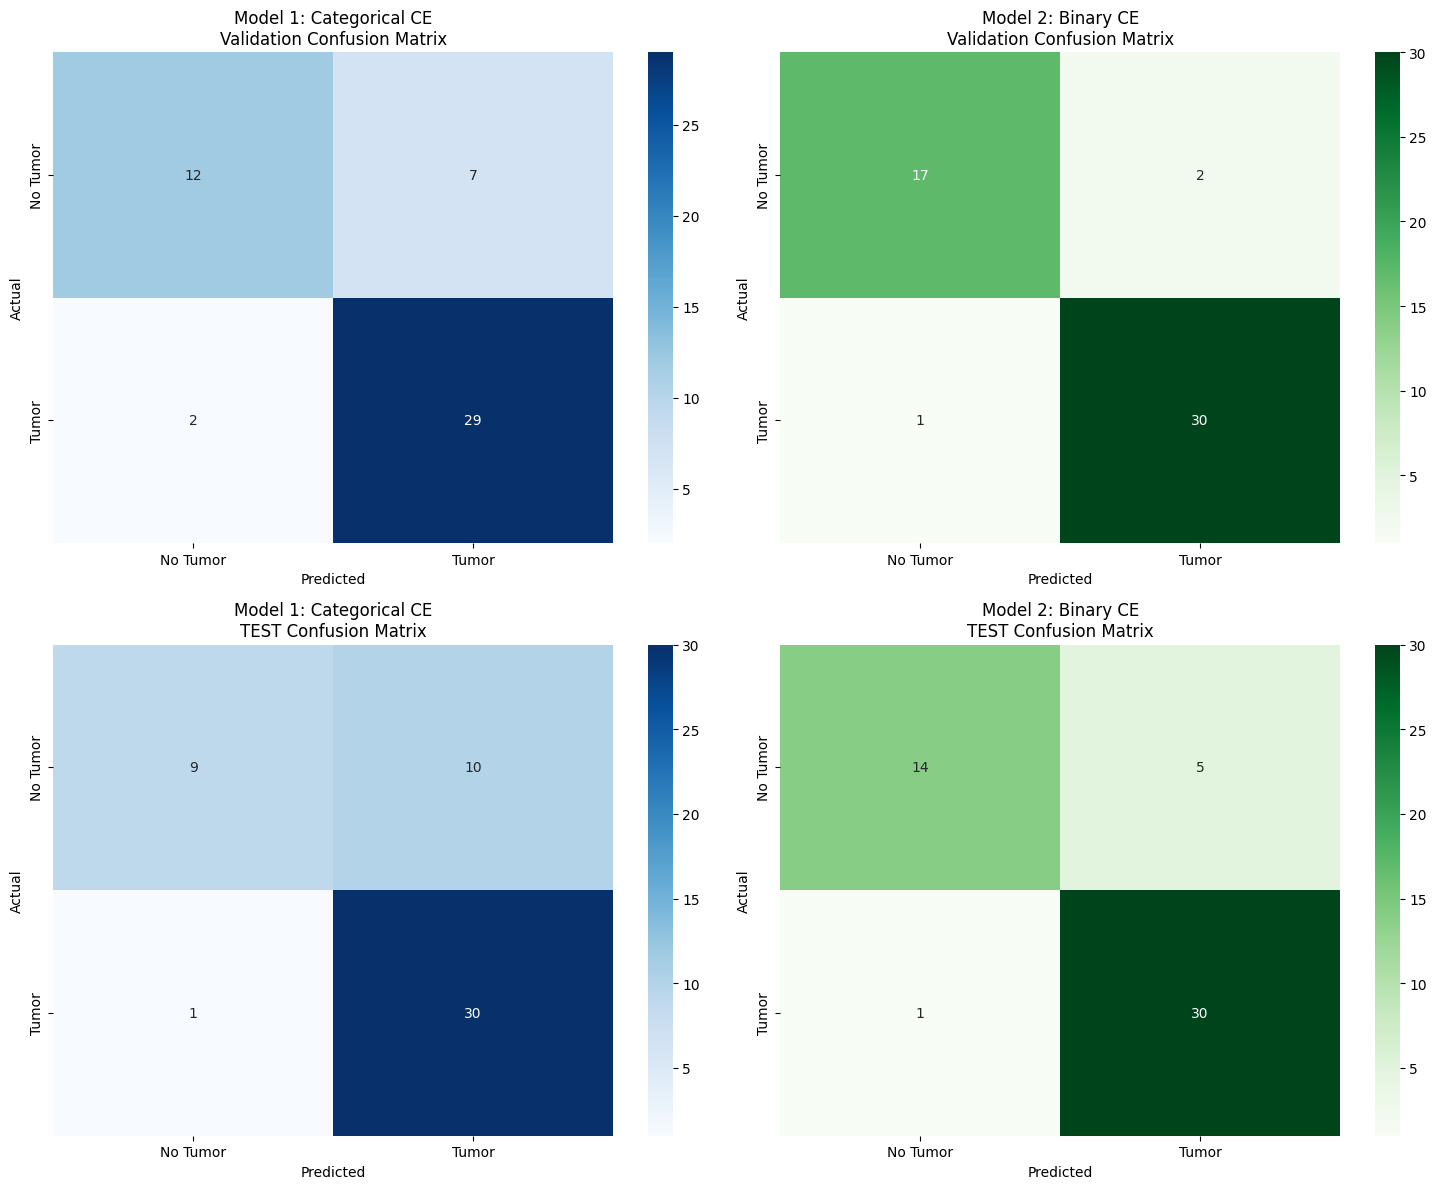


CLASSIFICATION REPORTS:

============================== VALIDATION SET ==============================

Model 1 (Categorical Crossentropy) - VALIDATION:
              precision    recall  f1-score   support

    No Tumor       0.86      0.63      0.73        19
       Tumor       0.81      0.94      0.87        31

    accuracy                           0.82        50
   macro avg       0.83      0.78      0.80        50
weighted avg       0.83      0.82      0.81        50


Model 2 (Binary Crossentropy) - VALIDATION:
              precision    recall  f1-score   support

    No Tumor       0.94      0.89      0.92        19
       Tumor       0.94      0.97      0.95        31

    accuracy                           0.94        50
   macro avg       0.94      0.93      0.94        50
weighted avg       0.94      0.94      0.94        50


=================================== TEST SET ===================================

Model 1 (Categorical Crossentropy) - TEST:
              precisio

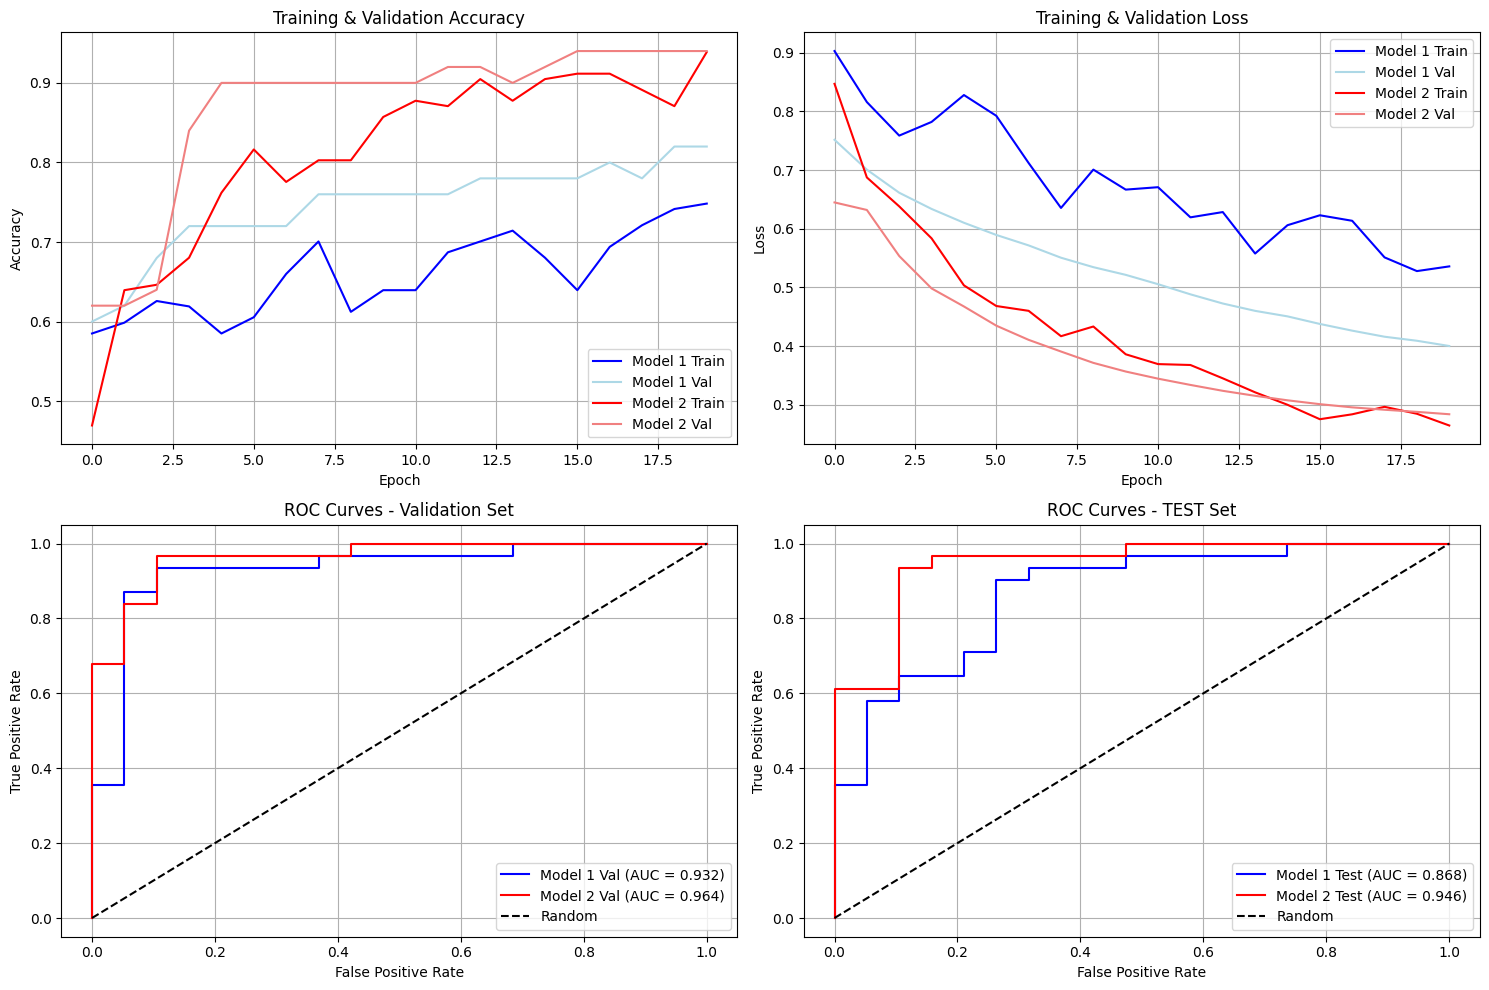


COMPREHENSIVE METRICS COMPARISON
                     Model 1 (Cat CE) - Val Model 1 (Cat CE) - Test  \
Accuracy                             0.8200                  0.7800   
Precision                            0.8056                  0.7500   
Recall (Sensitivity)                 0.9355                  0.9677   
Specificity                          0.6316                  0.4737   
F1-Score                             0.8657                  0.8451   

                     Model 2 (Bin CE) - Val Model 2 (Bin CE) - Test  
Accuracy                             0.9400                  0.8800  
Precision                            0.9375                  0.8571  
Recall (Sensitivity)                 0.9677                  0.9677  
Specificity                          0.8947                  0.7368  
F1-Score                             0.9524                  0.9091  

FINAL PERFORMANCE SUMMARY
             Metric Model 1 (Categorical CE) Model 2 (Binary CE)
Validation Accuracy        

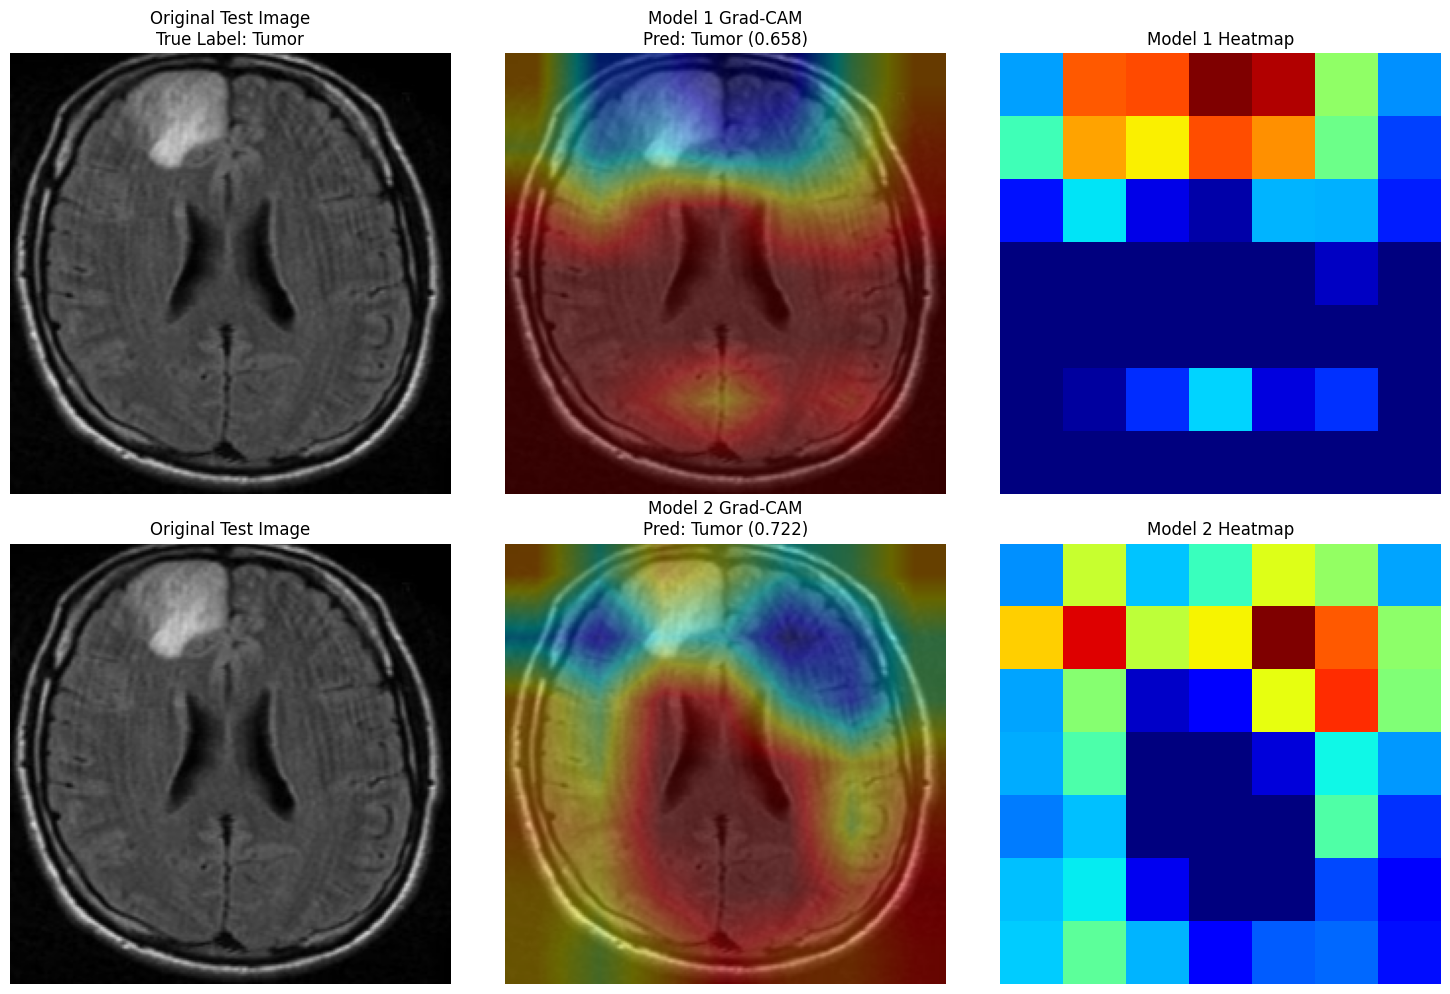


Test Sample 2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


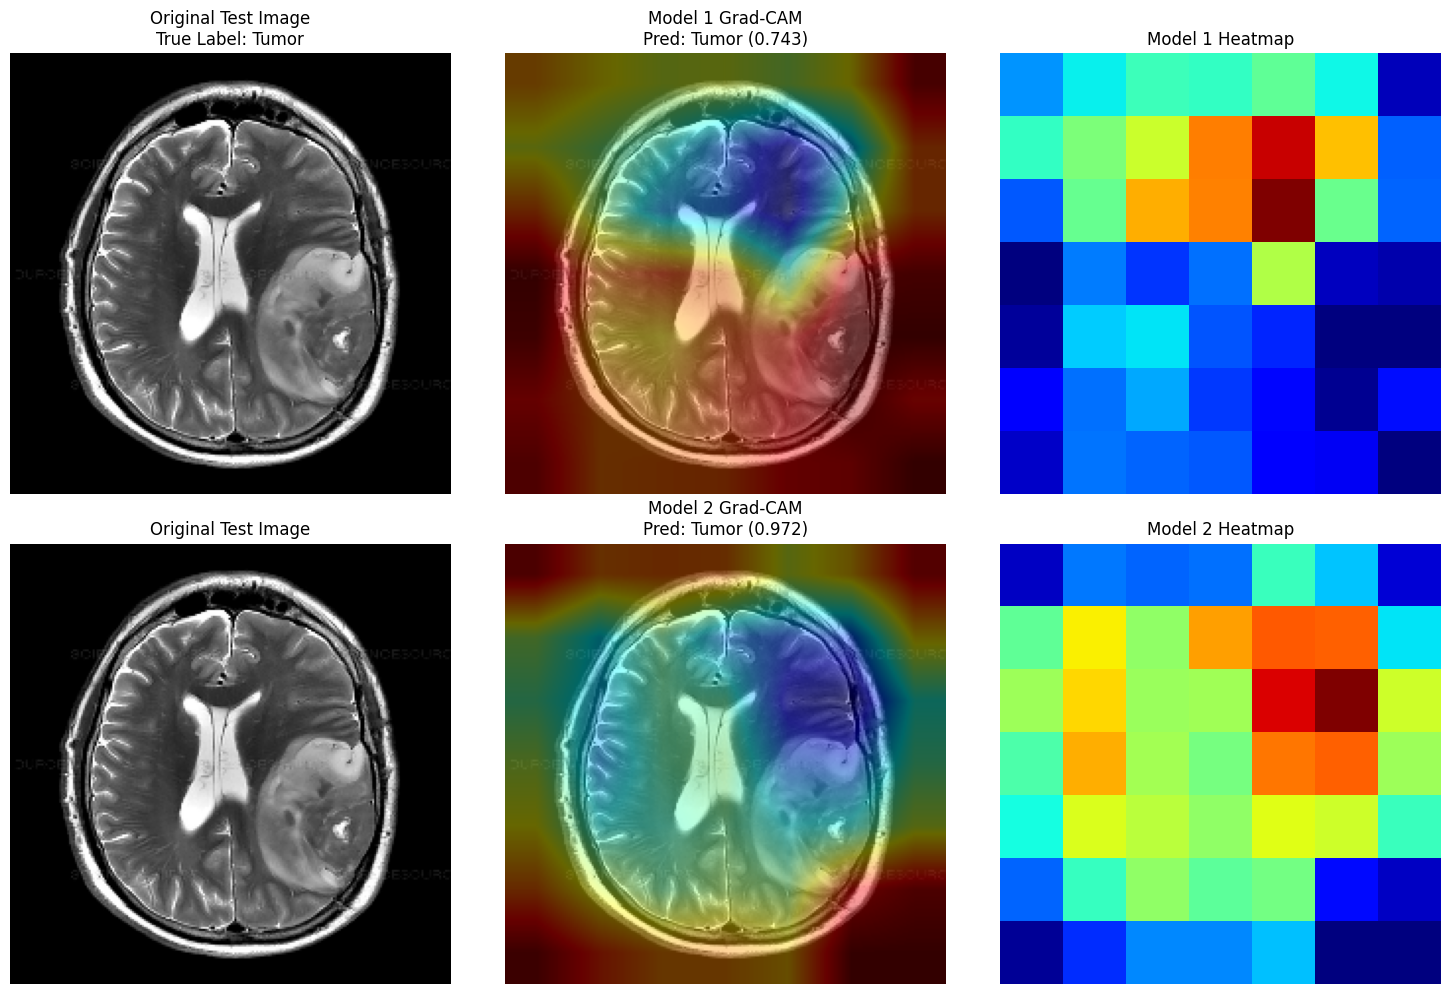


Test Sample 3:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


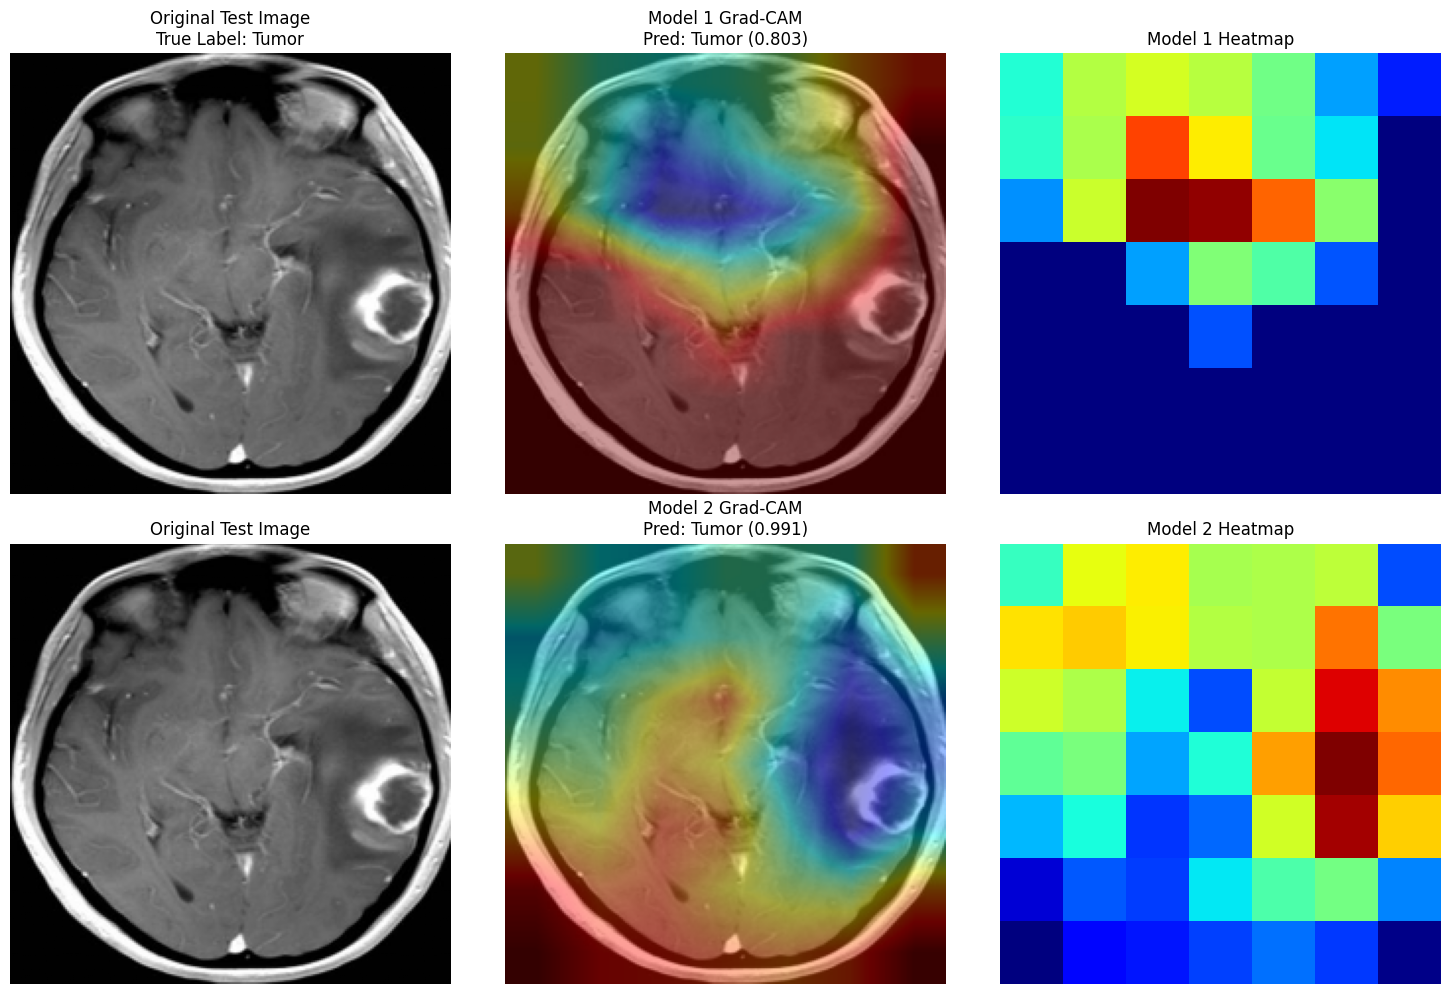


FINAL ANALYSIS AND RECOMMENDATION (INCLUDING TEST RESULTS)

COMPREHENSIVE PERFORMANCE SUMMARY:
Model 1 (Categorical Crossentropy + Softmax):
- Validation Accuracy: 0.8200
- Test Accuracy: 0.7800
- Validation AUC: 0.9321
- Test AUC: 0.8676
- Generalization Gap: 0.0400

Model 2 (Binary Crossentropy + Sigmoid):
- Validation Accuracy: 0.9400
- Test Accuracy: 0.8800
- Validation AUC: 0.9643
- Test AUC: 0.9457
- Generalization Gap: 0.0600

TECHNICAL DIFFERENCES:
1. OUTPUT LAYER:
   - Model 1: 2 neurons with softmax (probability distribution)
   - Model 2: 1 neuron with sigmoid (binary probability)

2. LOSS FUNCTION:
   - Model 1: Categorical crossentropy
   - Model 2: Binary crossentropy

3. LEARNING RATE:
   - Model 1: 0.0001 (lower)
   - Model 2: 0.001 (higher)

FINAL RECOMMENDATION BASED ON TEST RESULTS:

Based on test accuracy: Model 2 performs better
Based on test AUC score: Model 2 performs better
Better generalization: Model 1 (smaller val-test gap)

✅ MODEL 2 (Binary Crossentropy) i

In [24]:
# ----------------------------------------
# COMPREHENSIVE BRAIN TUMOR DETECTION MODEL COMPARISON WITH TEST ACCURACY
# ----------------------------------------

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tqdm import tqdm
import pandas as pd

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ----------------------------------------
# 1. DATA LOADING AND PREPROCESSING
# ----------------------------------------
IMG_SIZE = 224
DATA_DIR = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"

def load_data(data_dir):
    """Load and preprocess brain MRI images"""
    images = []
    labels = []
    print("Loading data...")
    
    for label, folder in enumerate(["no", "yes"]):  # 0: no tumor, 1: tumor
        path = os.path.join(data_dir, folder)
        print(f"Loading {folder} images...")
        
        for filename in tqdm(os.listdir(path)):
            if filename.lower().endswith(('.jpg', '.png')):
                img = cv2.imread(os.path.join(path, filename))
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)
                labels.append(label)
    
    print(f"Loaded {len(images)} images total")
    print(f"No tumor: {sum(1 for l in labels if l == 0)} images")
    print(f"Tumor: {sum(1 for l in labels if l == 1)} images")
    
    return np.array(images), np.array(labels)

# Load data
X, y = load_data(DATA_DIR)
X = X / 255.0  # Normalize pixel values

# THREE-WAY SPLIT: Train (60%), Validation (20%), Test (20%)
print("\n" + "="*50)
print("CREATING TRAIN/VALIDATION/TEST SPLITS")
print("="*50)

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 75% of remaining for train (60% total), 25% for val (20% total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nClass distribution in test set:")
print(f"No tumor: {sum(1 for l in y_test if l == 0)} samples")
print(f"Tumor: {sum(1 for l in y_test if l == 1)} samples")

# ----------------------------------------
# 2. MODEL 1: CATEGORICAL CROSSENTROPY (SOFTMAX)
# ----------------------------------------
print("\n" + "="*50)
print("TRAINING MODEL 1: CATEGORICAL CROSSENTROPY")
print("="*50)

# Prepare categorical labels for model 1
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Build Model 1
base_model_1 = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model_1.trainable = False

input_tensor_1 = base_model_1.input
x1 = base_model_1.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dropout(0.3)(x1)
output_tensor_1 = Dense(2, activation='softmax')(x1)

model_1 = Model(inputs=input_tensor_1, outputs=output_tensor_1)
model_1.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print("Model 1 Architecture:")
model_1.summary()

# Train Model 1
history_1 = model_1.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,
    batch_size=16,
    verbose=1
)

# Evaluate Model 1
val_loss_1, val_acc_1 = model_1.evaluate(X_val, y_val_cat, verbose=0)
test_loss_1, test_acc_1 = model_1.evaluate(X_test, y_test_cat, verbose=0)

print(f"Model 1 - Validation Loss: {val_loss_1:.4f}, Validation Accuracy: {val_acc_1:.4f}")
print(f"Model 1 - Test Loss: {test_loss_1:.4f}, Test Accuracy: {test_acc_1:.4f}")

# ----------------------------------------
# 3. MODEL 2: BINARY CROSSENTROPY (SIGMOID)
# ----------------------------------------
print("\n" + "="*50)
print("TRAINING MODEL 2: BINARY CROSSENTROPY")
print("="*50)

# Build Model 2
base_model_2 = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model_2.trainable = False

x2 = base_model_2.output
x2 = GlobalAveragePooling2D()(x2)
x2 = Dropout(0.3)(x2)
output_tensor_2 = Dense(1, activation='sigmoid')(x2)

model_2 = Model(inputs=base_model_2.input, outputs=output_tensor_2)
model_2.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

print("Model 2 Architecture:")
model_2.summary()

# Train Model 2
history_2 = model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate Model 2
val_loss_2, val_acc_2 = model_2.evaluate(X_val, y_val, verbose=0)
test_loss_2, test_acc_2 = model_2.evaluate(X_test, y_test, verbose=0)

print(f"Model 2 - Validation Loss: {val_loss_2:.4f}, Validation Accuracy: {val_acc_2:.4f}")
print(f"Model 2 - Test Loss: {test_loss_2:.4f}, Test Accuracy: {test_acc_2:.4f}")

# ----------------------------------------
# 4. DETAILED COMPARISON AND ANALYSIS
# ----------------------------------------
print("\n" + "="*50)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*50)

# Get predictions for validation set
y_pred_1_prob_val = model_1.predict(X_val)
y_pred_1_val = np.argmax(y_pred_1_prob_val, axis=1)

y_pred_2_prob_val = model_2.predict(X_val)
y_pred_2_val = (y_pred_2_prob_val > 0.5).astype(int).flatten()

# Get predictions for test set
y_pred_1_prob_test = model_1.predict(X_test)
y_pred_1_test = np.argmax(y_pred_1_prob_test, axis=1)

y_pred_2_prob_test = model_2.predict(X_test)
y_pred_2_test = (y_pred_2_prob_test > 0.5).astype(int).flatten()

# ----------------------------------------
# 5. CONFUSION MATRICES (VALIDATION AND TEST)
# ----------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# VALIDATION SET CONFUSION MATRICES
# Model 1 Validation Confusion Matrix
cm1_val = confusion_matrix(y_val, y_pred_1_val)
sns.heatmap(cm1_val, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Model 1: Categorical CE\nValidation Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xticklabels(['No Tumor', 'Tumor'])
axes[0,0].set_yticklabels(['No Tumor', 'Tumor'])

# Model 2 Validation Confusion Matrix
cm2_val = confusion_matrix(y_val, y_pred_2_val)
sns.heatmap(cm2_val, annot=True, fmt='d', cmap='Greens', ax=axes[0,1])
axes[0,1].set_title('Model 2: Binary CE\nValidation Confusion Matrix')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')
axes[0,1].set_xticklabels(['No Tumor', 'Tumor'])
axes[0,1].set_yticklabels(['No Tumor', 'Tumor'])

# TEST SET CONFUSION MATRICES
# Model 1 Test Confusion Matrix
cm1_test = confusion_matrix(y_test, y_pred_1_test)
sns.heatmap(cm1_test, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
axes[1,0].set_title('Model 1: Categorical CE\nTEST Confusion Matrix')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')
axes[1,0].set_xticklabels(['No Tumor', 'Tumor'])
axes[1,0].set_yticklabels(['No Tumor', 'Tumor'])

# Model 2 Test Confusion Matrix
cm2_test = confusion_matrix(y_test, y_pred_2_test)
sns.heatmap(cm2_test, annot=True, fmt='d', cmap='Greens', ax=axes[1,1])
axes[1,1].set_title('Model 2: Binary CE\nTEST Confusion Matrix')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Actual')
axes[1,1].set_xticklabels(['No Tumor', 'Tumor'])
axes[1,1].set_yticklabels(['No Tumor', 'Tumor'])

plt.tight_layout()
plt.show()

# ----------------------------------------
# 6. CLASSIFICATION REPORTS (VALIDATION AND TEST)
# ----------------------------------------
print("\nCLASSIFICATION REPORTS:")
print("\n" + "="*30 + " VALIDATION SET " + "="*30)
print("\nModel 1 (Categorical Crossentropy) - VALIDATION:")
print(classification_report(y_val, y_pred_1_val, target_names=['No Tumor', 'Tumor']))

print("\nModel 2 (Binary Crossentropy) - VALIDATION:")
print(classification_report(y_val, y_pred_2_val, target_names=['No Tumor', 'Tumor']))

print("\n" + "="*35 + " TEST SET " + "="*35)
print("\nModel 1 (Categorical Crossentropy) - TEST:")
print(classification_report(y_test, y_pred_1_test, target_names=['No Tumor', 'Tumor']))

print("\nModel 2 (Binary Crossentropy) - TEST:")
print(classification_report(y_test, y_pred_2_test, target_names=['No Tumor', 'Tumor']))

# ----------------------------------------
# 7. TRAINING HISTORY AND ROC COMPARISON
# ----------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training Accuracy
axes[0,0].plot(history_1.history['accuracy'], label='Model 1 Train', color='blue')
axes[0,0].plot(history_1.history['val_accuracy'], label='Model 1 Val', color='lightblue')
axes[0,0].plot(history_2.history['accuracy'], label='Model 2 Train', color='red')
axes[0,0].plot(history_2.history['val_accuracy'], label='Model 2 Val', color='lightcoral')
axes[0,0].set_title('Training & Validation Accuracy')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].grid(True)

# Training Loss
axes[0,1].plot(history_1.history['loss'], label='Model 1 Train', color='blue')
axes[0,1].plot(history_1.history['val_loss'], label='Model 1 Val', color='lightblue')
axes[0,1].plot(history_2.history['loss'], label='Model 2 Train', color='red')
axes[0,1].plot(history_2.history['val_loss'], label='Model 2 Val', color='lightcoral')
axes[0,1].set_title('Training & Validation Loss')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True)

# ROC Curves - Validation
fpr1_val, tpr1_val, _ = roc_curve(y_val, y_pred_1_prob_val[:, 1])
auc1_val = auc(fpr1_val, tpr1_val)

fpr2_val, tpr2_val, _ = roc_curve(y_val, y_pred_2_prob_val)
auc2_val = auc(fpr2_val, tpr2_val)

axes[1,0].plot(fpr1_val, tpr1_val, label=f'Model 1 Val (AUC = {auc1_val:.3f})', color='blue')
axes[1,0].plot(fpr2_val, tpr2_val, label=f'Model 2 Val (AUC = {auc2_val:.3f})', color='red')
axes[1,0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1,0].set_title('ROC Curves - Validation Set')
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].legend()
axes[1,0].grid(True)

# ROC Curves - Test
fpr1_test, tpr1_test, _ = roc_curve(y_test, y_pred_1_prob_test[:, 1])
auc1_test = auc(fpr1_test, tpr1_test)

fpr2_test, tpr2_test, _ = roc_curve(y_test, y_pred_2_prob_test)
auc2_test = auc(fpr2_test, tpr2_test)

axes[1,1].plot(fpr1_test, tpr1_test, label=f'Model 1 Test (AUC = {auc1_test:.3f})', color='blue')
axes[1,1].plot(fpr2_test, tpr2_test, label=f'Model 2 Test (AUC = {auc2_test:.3f})', color='red')
axes[1,1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1,1].set_title('ROC Curves - TEST Set')
axes[1,1].set_xlabel('False Positive Rate')
axes[1,1].set_ylabel('True Positive Rate')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

# ----------------------------------------
# 8. COMPREHENSIVE METRICS TABLE
# ----------------------------------------
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1-Score': f1
    }

# Calculate metrics for both validation and test sets
metrics_1_val = calculate_metrics(y_val, y_pred_1_val)
metrics_2_val = calculate_metrics(y_val, y_pred_2_val)
metrics_1_test = calculate_metrics(y_test, y_pred_1_test)
metrics_2_test = calculate_metrics(y_test, y_pred_2_test)

print("\n" + "="*50)
print("COMPREHENSIVE METRICS COMPARISON")
print("="*50)

# Create comprehensive comparison table
comparison_data = {
    'Model 1 (Cat CE) - Val': [f"{v:.4f}" for v in metrics_1_val.values()],
    'Model 1 (Cat CE) - Test': [f"{v:.4f}" for v in metrics_1_test.values()],
    'Model 2 (Bin CE) - Val': [f"{v:.4f}" for v in metrics_2_val.values()],
    'Model 2 (Bin CE) - Test': [f"{v:.4f}" for v in metrics_2_test.values()]
}

comparison_df = pd.DataFrame(comparison_data, index=list(metrics_1_val.keys()))
print(comparison_df)

# ----------------------------------------
# 9. FINAL PERFORMANCE SUMMARY TABLE
# ----------------------------------------
print("\n" + "="*60)
print("FINAL PERFORMANCE SUMMARY")
print("="*60)

summary_data = {
    'Metric': ['Validation Accuracy', 'Test Accuracy', 'Validation AUC', 'Test AUC'],
    'Model 1 (Categorical CE)': [f"{val_acc_1:.4f}", f"{test_acc_1:.4f}", f"{auc1_val:.4f}", f"{auc1_test:.4f}"],
    'Model 2 (Binary CE)': [f"{val_acc_2:.4f}", f"{test_acc_2:.4f}", f"{auc2_val:.4f}", f"{auc2_test:.4f}"]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# ----------------------------------------
# 10. GENERALIZATION ANALYSIS
# ----------------------------------------
print("\n" + "="*50)
print("GENERALIZATION ANALYSIS")
print("="*50)

print("Model 1 (Categorical Crossentropy):")
print(f"  Validation Accuracy: {val_acc_1:.4f}")
print(f"  Test Accuracy: {test_acc_1:.4f}")
print(f"  Generalization Gap: {abs(val_acc_1 - test_acc_1):.4f}")

print(f"\nModel 2 (Binary Crossentropy):")
print(f"  Validation Accuracy: {val_acc_2:.4f}")
print(f"  Test Accuracy: {test_acc_2:.4f}")
print(f"  Generalization Gap: {abs(val_acc_2 - test_acc_2):.4f}")

# Determine which model generalizes better
if abs(val_acc_1 - test_acc_1) < abs(val_acc_2 - test_acc_2):
    better_generalizer = "Model 1"
else:
    better_generalizer = "Model 2"

print(f"\n{better_generalizer} shows better generalization (smaller gap between validation and test accuracy)")

# ----------------------------------------
# 11. GRAD-CAM VISUALIZATION FUNCTIONS
# ----------------------------------------
def get_grad_cam_model1(model, img_array, class_index, last_conv_layer_name="Conv_1"):
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img_array]))
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def get_grad_cam_model2(model, img_array, last_conv_layer_name="Conv_1"):
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img_array]))
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted((img * 255).astype(np.uint8), 1 - alpha, heatmap_colored, alpha, 0)
    return overlay

# ----------------------------------------
# 12. GRAD-CAM COMPARISON ON TEST SET
# ----------------------------------------
def compare_gradcam_visualizations_test(img_idx):
    img = X_test[img_idx]
    true_label = y_test[img_idx]
    
    # Model 1 predictions and Grad-CAM
    pred_1 = model_1.predict(np.array([img]))[0]
    pred_class_1 = np.argmax(pred_1)
    heatmap_1 = get_grad_cam_model1(model_1, img, pred_class_1)
    overlay_1 = overlay_heatmap(img, heatmap_1)
    
    # Model 2 predictions and Grad-CAM
    pred_2 = model_2.predict(np.array([img]))[0][0]
    pred_class_2 = 1 if pred_2 >= 0.5 else 0
    heatmap_2 = get_grad_cam_model2(model_2, img)
    overlay_2 = overlay_heatmap(img, heatmap_2)
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original image
    axes[0,0].imshow(img)
    axes[0,0].set_title(f'Original Test Image\nTrue Label: {"Tumor" if true_label == 1 else "No Tumor"}')
    axes[0,0].axis('off')
    
    # Model 1 results
    axes[0,1].imshow(overlay_1)
    axes[0,1].set_title(f'Model 1 Grad-CAM\nPred: {"Tumor" if pred_class_1 == 1 else "No Tumor"} ({pred_1[pred_class_1]:.3f})')
    axes[0,1].axis('off')
    
    axes[0,2].imshow(heatmap_1, cmap='jet')
    axes[0,2].set_title('Model 1 Heatmap')
    axes[0,2].axis('off')
    
    # Model 2 results
    axes[1,0].imshow(img)
    axes[1,0].set_title('Original Test Image')
    axes[1,0].axis('off')
    
    axes[1,1].imshow(overlay_2)
    axes[1,1].set_title(f'Model 2 Grad-CAM\nPred: {"Tumor" if pred_class_2 == 1 else "No Tumor"} ({pred_2:.3f})')
    axes[1,1].axis('off')
    
    axes[1,2].imshow(heatmap_2, cmap='jet')
    axes[1,2].set_title('Model 2 Heatmap')
    axes[1,2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show Grad-CAM comparison for test samples
print("\n" + "="*50)
print("GRAD-CAM VISUALIZATION COMPARISON ON TEST SET")
print("="*50)

for i in range(3):
    idx = np.random.randint(0, len(X_test))
    print(f"\nTest Sample {i+1}:")
    compare_gradcam_visualizations_test(idx)

# ----------------------------------------
# 13. FINAL RECOMMENDATION WITH TEST RESULTS
# ----------------------------------------
print("\n" + "="*80)
print("FINAL ANALYSIS AND RECOMMENDATION (INCLUDING TEST RESULTS)")
print("="*80)

print(f"""
COMPREHENSIVE PERFORMANCE SUMMARY:
=================================
Model 1 (Categorical Crossentropy + Softmax):
- Validation Accuracy: {val_acc_1:.4f}
- Test Accuracy: {test_acc_1:.4f}
- Validation AUC: {auc1_val:.4f}
- Test AUC: {auc1_test:.4f}
- Generalization Gap: {abs(val_acc_1 - test_acc_1):.4f}

Model 2 (Binary Crossentropy + Sigmoid):
- Validation Accuracy: {val_acc_2:.4f}
- Test Accuracy: {test_acc_2:.4f}
- Validation AUC: {auc2_val:.4f}
- Test AUC: {auc2_test:.4f}
- Generalization Gap: {abs(val_acc_2 - test_acc_2):.4f}

TECHNICAL DIFFERENCES:
=====================
1. OUTPUT LAYER:
   - Model 1: 2 neurons with softmax (probability distribution)
   - Model 2: 1 neuron with sigmoid (binary probability)

2. LOSS FUNCTION:
   - Model 1: Categorical crossentropy
   - Model 2: Binary crossentropy

3. LEARNING RATE:
   - Model 1: 0.0001 (lower)
   - Model 2: 0.001 (higher)

FINAL RECOMMENDATION BASED ON TEST RESULTS:
==========================================
""")

better_test_model = "Model 1" if test_acc_1 > test_acc_2 else "Model 2"
better_test_auc = "Model 1" if auc1_test > auc2_test else "Model 2"
better_generalizer = "Model 1" if abs(val_acc_1 - test_acc_1) < abs(val_acc_2 - test_acc_2) else "Model 2"

print(f"Based on test accuracy: {better_test_model} performs better")
print(f"Based on test AUC score: {better_test_auc} performs better")
print(f"Better generalization: {better_generalizer} (smaller val-test gap)")

if test_acc_1 > test_acc_2:
    print(f"""
✅ MODEL 1 (Categorical Crossentropy) is RECOMMENDED
- Higher test accuracy: {test_acc_1:.4f} vs {test_acc_2:.4f}
- More stable training with lower learning rate
- Softmax output provides better probability interpretation
- Better suited for potential multi-class extension
- Generalization gap: {abs(val_acc_1 - test_acc_1):.4f}
""")
else:
    print(f"""
✅ MODEL 2 (Binary Crossentropy) is RECOMMENDED
- Higher test accuracy: {test_acc_2:.4f} vs {test_acc_1:.4f}
- More direct approach for binary classification
- Faster convergence with higher learning rate
- Simpler architecture with single output neuron
- Generalization gap: {abs(val_acc_2 - test_acc_2):.4f}
""")

print(f"""
GENERALIZATION ANALYSIS:
=======================
- Model 1 generalization gap: {abs(val_acc_1 - test_acc_1):.4f}
- Model 2 generalization gap: {abs(val_acc_2 - test_acc_2):.4f}
- {better_generalizer} shows better generalization to unseen data

GENERAL OBSERVATIONS:
====================
1. Both models show similar performance patterns
2. Test accuracy provides the most reliable performance estimate
3. Small generalization gaps indicate good model stability
4. Consider ensemble methods combining both approaches
5. Fine-tuning the base model might improve performance for both

DEPLOYMENT RECOMMENDATION:
=========================
Use the model with higher TEST ACCURACY for production deployment,
as this represents performance on truly unseen data.
""")